In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#Loading the necessary libraries-----------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import mannwhitneyu
import os
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import precision_score, recall_score, make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import optimizers
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
### loading the Data
TrainBenign_df = pd.read_csv("../TrainBenign.csv")
TrainPathogenic_df = pd.read_csv("../TrainPathogenic.csv")
TestBenign_df = pd.read_csv("../TestBenign.csv")
TestPathogenic_df = pd.read_csv("../TestPathogenic.csv")

In [4]:
TrainBenign_df = TrainBenign_df.dropna(how="any")
TrainPathogenic_df = TrainPathogenic_df.dropna(how="any")
TestBenign_df = TestBenign_df.dropna(how="any")
TestPathogenic_df = TestPathogenic_df.dropna(how="any")

In [5]:
#Defining a list of all columns with a single unique value. Add Pdb, Mutation and Variant columns since they have no relevance in downstream analysis
col_to_drop = [
 'Pdb', 
 'Mutation', 
 'Variant',
 'sloop_entropy',
 'mloop_entropy',
 'Water_bridge',
 'Electrostatic_kon',
 'Partial_covalent_bonds',
 'Entropy_Complex',
 'dShort_Loop_Entropy',
 'dMedium_Loop_Entropy',
 'dWater_Bridge',
 'dElectrostatic_kon',
 'dPartial_Covalent_Bonds',
 'dEntropy_Complex'
]

In [6]:
#Dropping the defined columns 
TrainBenign_df = TrainBenign_df.drop(columns=col_to_drop)
TrainPathogenic_df = TrainPathogenic_df.drop(columns=col_to_drop)
TestBenign_df = TestBenign_df.drop(columns=col_to_drop)
TestPathogenic_df = TestPathogenic_df.drop(columns=col_to_drop)

In [7]:
train_df = [TrainBenign_df, TrainPathogenic_df] #Two categories of train dataframe
test_df = [TestBenign_df, TestPathogenic_df] #Two categories of test dataframe

#Merge and shuffle the data. Reset index after shuffling to ensure clean indices 
train = pd.concat(train_df).sample(frac=1).reset_index(drop=True)
test = pd.concat(test_df).sample(frac=1).reset_index(drop=True)

In [8]:
#Let's encode target labels with Pathogenic as 1 and 0 as Benign
train["Class"] = np.where(train["Class"]=="Pathogenic", 1, 0)
test["Class"] = np.where(test["Class"]=="Pathogenic", 1, 0)

In [9]:
#Prepare the train and test set subset and encode the target labels with 0s and 1s
X_train, y_train = train.drop(columns="Class"), train["Class"]
X_test, y_test = test.drop(columns="Class"), test["Class"]

In [10]:
def scale_datasets(X_train, X_test):
    """
    Standard Scale test and train data
    """
    std_scaler = StandardScaler()
    scaled_X_train = std_scaler.fit_transform(X_train)
    scaled_X_test = std_scaler.transform(X_test)
    return scaled_X_train, scaled_X_test
  
scaled_X_train, scaled_X_test = scale_datasets(X_train, X_test)

In [11]:
class AutoEncoders(Model):

    def __init__(self, input_dim, output_units):
        super().__init__()
        self.encoder = Sequential(
            [
                Dense(32, activation="relu", input_shape=(scaled_X_train.shape[1],)),
                Dense(16, activation="relu")
            ],
            name="encoder"
        )

        self.decoder = Sequential(
            [
                Dense(16, activation="relu"),
                Dense(32, activation="relu"),
                Dense(output_units, activation="sigmoid")
            ]
        )

    def call(self, inputs, training=None, mask=None):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

auto_encoder = AutoEncoders(scaled_X_train.shape[1], output_units=scaled_X_train.shape[1])
optimizer = optimizers.Adam(learning_rate=0.005)
auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer=optimizer
)

history = auto_encoder.fit(
    scaled_X_train, 
    scaled_X_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(scaled_X_test, 
                     scaled_X_test)
)

Epoch 1/50
421/421 [==============================] - 2s 2ms/step - loss: 0.5288 - mae: 0.5288 - val_loss: 0.4911 - val_mae: 0.4911
Epoch 2/50
421/421 [==============================] - 1s 2ms/step - loss: 0.4970 - mae: 0.4970 - val_loss: 0.4832 - val_mae: 0.4832
Epoch 3/50
421/421 [==============================] - 1s 2ms/step - loss: 0.4891 - mae: 0.4891 - val_loss: 0.4751 - val_mae: 0.4751
Epoch 4/50
421/421 [==============================] - 1s 2ms/step - loss: 0.4812 - mae: 0.4812 - val_loss: 0.4661 - val_mae: 0.4661
Epoch 5/50
421/421 [==============================] - 1s 2ms/step - loss: 0.4744 - mae: 0.4744 - val_loss: 0.4654 - val_mae: 0.4654
Epoch 6/50
421/421 [==============================] - 1s 2ms/step - loss: 0.4732 - mae: 0.4732 - val_loss: 0.4621 - val_mae: 0.4621
Epoch 7/50
421/421 [==============================] - 1s 2ms/step - loss: 0.4709 - mae: 0.4709 - val_loss: 0.4633 - val_mae: 0.4633
Epoch 8/50
421/421 [==============================] - 1s 2ms/step - loss: 0.

In [12]:
encoder_layer = auto_encoder.get_layer("encoder")
reduced_train = pd.DataFrame(encoder_layer.predict(scaled_X_train))
reduced_train = reduced_train.add_prefix('feature_')

reduced_test = pd.DataFrame(encoder_layer.predict(scaled_X_test))
reduced_test = reduced_test.add_prefix('feature_')

96/96 [==============================] - 0s 854us/step


In [13]:
#Defining a function to identify columns with a single unique count
def show_single_uniq_col(df):
    single_uniq_col = [col for col in df.columns if df[col].nunique() in (1,2)]
    return single_uniq_col

In [14]:
col = show_single_uniq_col(reduced_train)
col

['feature_6', 'feature_8', 'feature_13']

In [15]:
col = show_single_uniq_col(reduced_train)
X_train = reduced_train.drop(columns=col)
X_test = reduced_test.drop(columns=col)

In [16]:
# Create a Decision Tree model
dt = DecisionTreeClassifier(criterion="entropy",
                            max_depth=4,
                            min_samples_split=0.25,
                            min_samples_leaf=2,
                            max_features="sqrt",
                            max_leaf_nodes=6,
                            random_state=42)

#Fit the dt on the train set
dt.fit(X_train, y_train) 
#Use dt to predict the test set labels
test_y_pred = dt.predict(X_test) 
train_y_pred = dt.predict(X_train) 

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

Test Model Recall: 0.46

Train Model Recall: 0.50

Test Model Precision: 0.55

Train Model Precision: 0.69



Text(0.5, 1.0, 'Decision Tree Visualization')

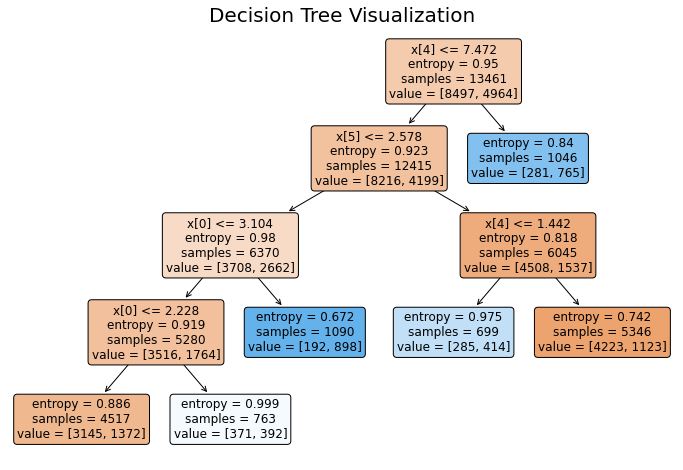

In [17]:
# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt, filled=True,
          rounded=True,
          fontsize=12)
plt.title("Decision Tree Visualization", fontsize=20)

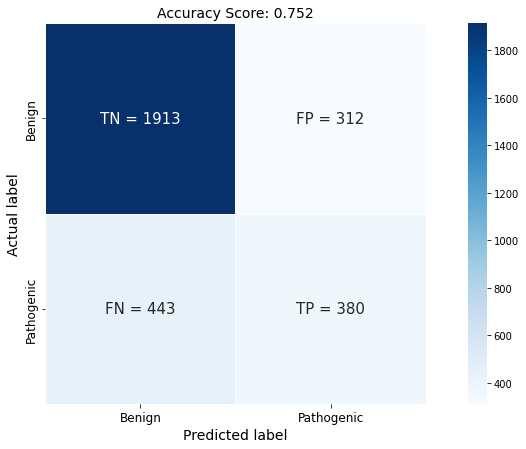

In [18]:
# Generate a confusion matrix
cm = metrics.confusion_matrix(y_test, dt.predict(X_test))
score = dt.score(X_test, y_test, )
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)

In [19]:
#Define the parameter grid for GridSearchCV
param_grid = {
    "criterion": ["gini", "entropy"],
    "min_samples_split": [4, 6, 8],
    "min_samples_leaf": [4, 6, 8],
    "max_depth": [4, 6, 8],
    "max_features": ["sqrt", 0.75, 1.0],
    "max_leaf_nodes": [3, 4, 6]}

#Initialize the DecisionTreeClassifier model
dt_model = DecisionTreeClassifier(random_state=42)

#Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, 
                           param_grid=param_grid, 
                           cv=5, scoring="accuracy", n_jobs=-1)

#Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)

#Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#Make predictions on the test set using the best model
test_y_pred = best_model.predict(X_test)
train_y_pred = best_model.predict(X_train)

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

Test Model Recall: 0.39

Train Model Recall: 0.44

Test Model Precision: 0.64

Train Model Precision: 0.77



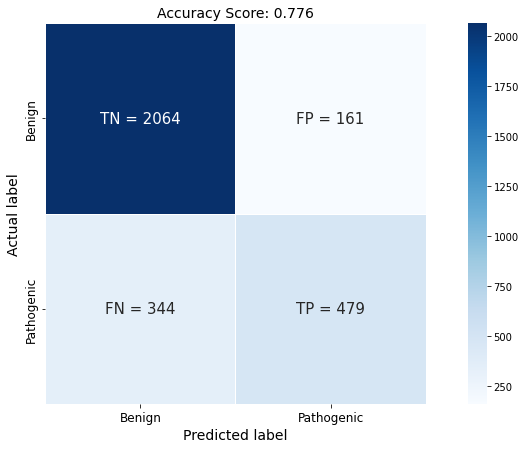

In [24]:
# Generate a confusion matrix
cm = metrics.confusion_matrix(y_test, test_y_pred )
score = best_model.score(X_test, y_test)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)

In [32]:
#BaggingClassifier which trains an ensemble of 200 Decision Tree classifiers
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(),
                n_estimators=500,
                max_samples=0.25,
                max_features=0.75,
                bootstrap_features=True,
                bootstrap=True,
                n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train) #Fit the dt on the trainind set
#Make prediction
test_y_pred = bag_clf.predict(X_test)
train_y_pred = bag_clf.predict(X_train)

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

Test Model Recall: 0.58

Train Model Recall: 0.86

Test Model Precision: 0.75

Train Model Precision: 0.95



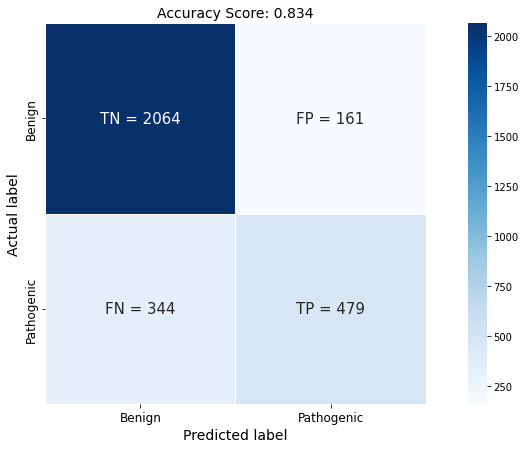

In [33]:
# Generate a confusion matrix
cm = metrics.confusion_matrix(y_test, test_y_pred)
score = bag_clf.score(X_test, y_test)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)
     

In [34]:
#Train random forest model
rf_clf = RandomForestClassifier(n_estimators=500,
                       criterion="gini",
                       max_depth=4,
                       min_samples_leaf=4,
                       max_features="sqrt",
                       bootstrap=True,
                       n_jobs=-1, random_state=42)

#Fit the dt on the trainind set
rf_clf.fit(X_train, y_train) #Fit the dt on the trainind set
#Make prediction
test_y_pred = rf_clf.predict(X_test)
train_y_pred = rf_clf.predict(X_train)

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

Test Model Recall: 0.38

Train Model Recall: 0.44

Test Model Precision: 0.75

Train Model Precision: 0.85



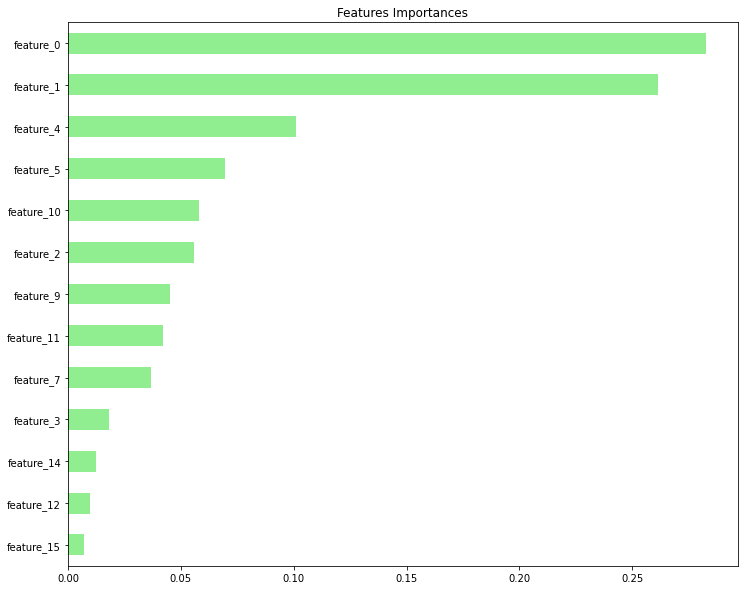

In [35]:
# Extract feature importances
importances = pd.Series(data=rf_clf.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values() # Sort importances

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(12, 10))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

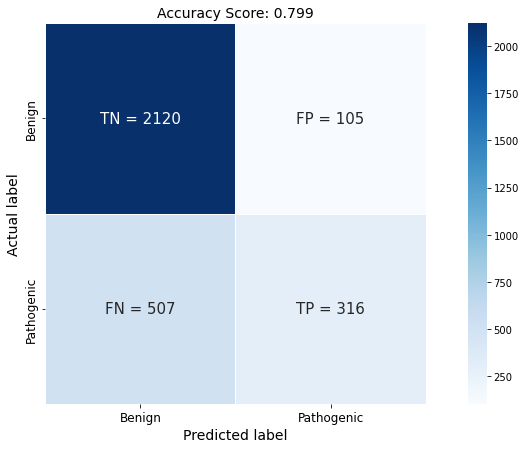

In [36]:
# Generate a confusion matrix
cm = metrics.confusion_matrix(y_test, test_y_pred)
score = rf_clf.score(X_test, y_test)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)

In [37]:
#Define the parameter grid for GridSearchCV
param_grid = {"n_estimators": [50, 100, 500],
              "criterion": ["gini", "entropy"],
              "min_samples_leaf": [2, 4, 6],
              "max_depth": [2, 4, 6],
              "max_features": ["sqrt", 0.7, 0.8],
              "max_leaf_nodes": [4, 6, 8]}

#Initialize the RandomForestClassifier model
rf_clf_model = RandomForestClassifier(
                       bootstrap=True,
                       oob_score=True,
                       n_jobs=-1, random_state=42)

#Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf_model, 
                           param_grid=param_grid, 
                           cv=5, n_jobs=-1)

#Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#Make predictions on the test set using the best model
test_y_pred = best_model.predict(X_test)
train_y_pred = best_model.predict(X_train)

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

Test Model Recall: 0.38

Train Model Recall: 0.44

Test Model Precision: 0.74

Train Model Precision: 0.83



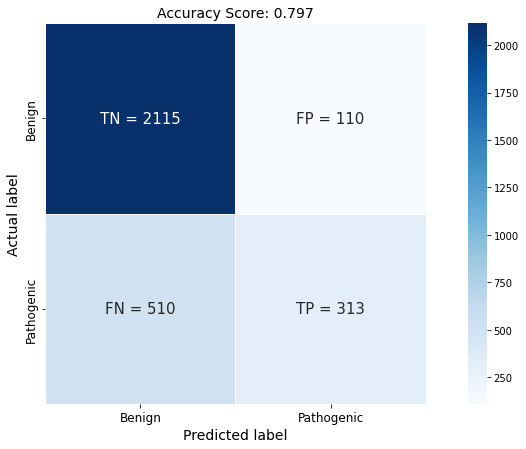

In [38]:
# Generate a confusion matrix
cm = metrics.confusion_matrix(y_test, test_y_pred)
score = best_model.score(X_test, y_test)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)

In [40]:
#Initialize Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=500,
                        learning_rate=0.1,
                        max_depth=4,
                        random_state=42)

#Fit classifier on train set
gb_clf.fit(X_train, y_train) 
#Compute accuracy for each stage of the boosting process
acc_score = [accuracy_score(y_test, y_pred) for y_pred in gb_clf.staged_predict(X_test)]
#Find the optimal number of estimators
bst_n_estimators = np.argmax(acc_score )+1

#Reinitialize the model with the optimal number of estimators
gb_clf_best = GradientBoostingClassifier(
                                    n_estimators=bst_n_estimators,
                                    learning_rate=0.1,
                                    max_depth=4,  
                                    random_state=42)

#Retrain gb_clf_best on the train set
gb_clf_best.fit(X_train, y_train) 
#Evaluate the accuracy of the model
test_y_pred = gb_clf_best.predict(X_test) 
train_y_pred = gb_clf_best.predict(X_train)

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n") 

Test Model Recall: 0.63

Train Model Recall: 0.80

Test Model Precision: 0.70

Train Model Precision: 0.88



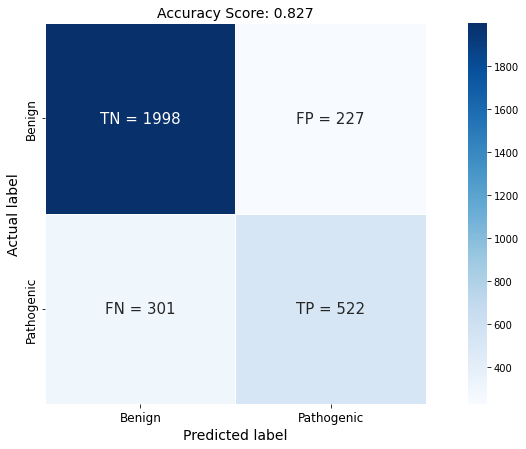

In [41]:
# Generate a confusion matrix
cm = metrics.confusion_matrix( y_test, test_y_pred)
score = gb_clf_best.score(X_test, y_test)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)

In [42]:
#Define the parameter grid for GridSearchCV
param_grid = {
    "learning_rate": [0.1, 0.15, 2],
    "min_samples_leaf": [2, 4, 6],
    "max_depth":[3, 4, 6],
    "max_features":[None, "sqrt", 0.75],
    "subsample":[0.65, 0.75, 1.0],
    "n_estimators": [100, 200, 500],
    }

# Initialize the Gradient Boosting model
gbclf_model = GradientBoostingClassifier(random_state=42)

#Initialize GridSearchCV and pass in the scoring function 
grid_search = GridSearchCV(estimator=gbclf_model, 
                           param_grid=param_grid,
                           scoring="accuracy",
                           cv=5, n_jobs=-1)

# Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)
# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#Make class label predictions on the test set using the best model
test_y_pred = best_model.predict(X_test)
train_y_pred = best_model.predict(X_train)

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

Test Model Recall: 0.65

Train Model Recall: 1.00

Test Model Precision: 0.66

Train Model Precision: 1.00



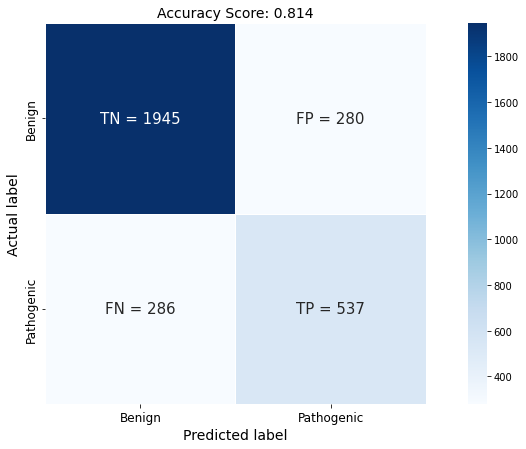

In [43]:
# Generate a confusion matrix
cm = metrics.confusion_matrix(y_test, test_y_pred)
score = best_model.score(X_test, y_test)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)

In [44]:
#Instantiate the XGBClassifier: xg_cl
xg_clf = xgb.XGBClassifier(objective='binary:logistic', 
                           n_estimators=500, 
                           eta=0.15,
                           max_depth=12,
                           eval_metric = "error",
                           early_stopping_rounds=10, 
                           random_state=42)

#Fit the classifier to the training set
xg_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
#Predict the labels of the test set: preds
y_pred = xg_clf.predict(X_test)
test_y_pred = xg_clf.predict(X_test)

#Make class label predictions on the test set using the best model
test_y_pred = xg_clf.predict(X_test)
train_y_pred = xg_clf.predict(X_train)

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

[0]	validation_0-error:0.23294
[1]	validation_0-error:0.21129
[2]	validation_0-error:0.20177
[3]	validation_0-error:0.20013
[4]	validation_0-error:0.19619
[5]	validation_0-error:0.19324
[6]	validation_0-error:0.18898
[7]	validation_0-error:0.18766
[8]	validation_0-error:0.18963
[9]	validation_0-error:0.18668
[10]	validation_0-error:0.18734
[11]	validation_0-error:0.18734
[12]	validation_0-error:0.18832
[13]	validation_0-error:0.18570
[14]	validation_0-error:0.18766
[15]	validation_0-error:0.18274
[16]	validation_0-error:0.18504
[17]	validation_0-error:0.18143
[18]	validation_0-error:0.17881
[19]	validation_0-error:0.17913
[20]	validation_0-error:0.17979
[21]	validation_0-error:0.17749
[22]	validation_0-error:0.17979
[23]	validation_0-error:0.18176
[24]	validation_0-error:0.18110
[25]	validation_0-error:0.18176
[26]	validation_0-error:0.17913
[27]	validation_0-error:0.17913
[28]	validation_0-error:0.17782
[29]	validation_0-error:0.17585
[30]	validation_0-error:0.17552
[31]	validation_0-

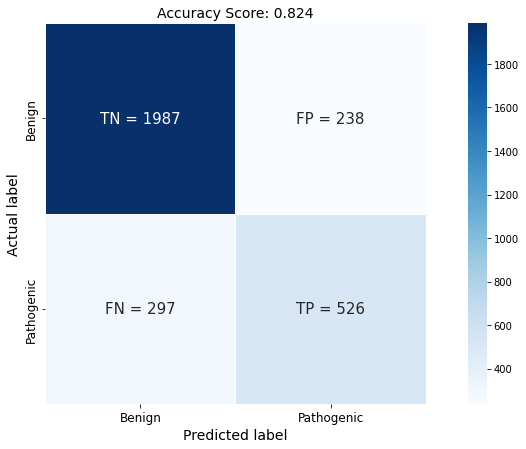

In [45]:
# Generate a confusion matrix
cm = metrics.confusion_matrix(y_test, test_y_pred)
score = xg_clf.score(X_test, y_test)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)

In [47]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "learning_rate": [0.1, 0.15, 0.2],
    "min_child_weight": [4, 6, 8],
    "max_depth": [6, 8, 12],
    "colsample_bytree": [0.5, 0.75, 1.0],
    "subsample": [0.65, 0.75, 1.0],
    "n_estimators": [100, 200, 500],
}

# Instantiate the XGBClassifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Initialize GridSearchCV and pass in the scoring function 
xgb_grid_search = GridSearchCV(estimator=xgb_model, 
                               param_grid=param_grid,
                               scoring="accuracy",
                               cv=5, n_jobs=-1)

# Fit the model to the training data using GridSearchCV
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters and best model
xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_

# Make class label predictions on the test set using the best model
test_y_pred = xgb_best_model.predict(X_test)
train_y_pred = xgb_best_model.predict(X_train)

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

Test Model Recall: 0.65

Train Model Recall: 1.00

Test Model Precision: 0.67

Train Model Precision: 1.00



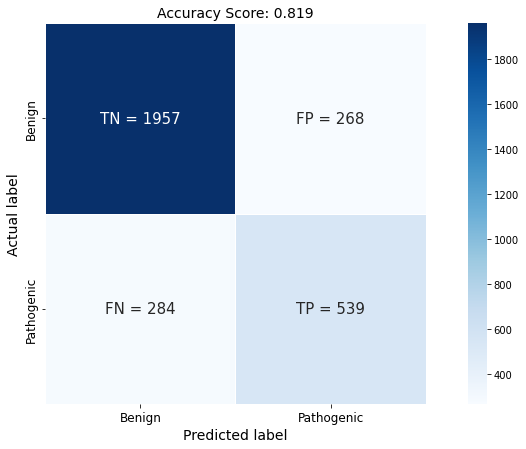

In [48]:
# Generate a confusion matrix
cm = metrics.confusion_matrix(y_test, test_y_pred)
score = xgb_best_model.score(X_test, y_test)
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(15,7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Benign', 'Pathogenic'],
            yticklabels = ['Benign', 'Pathogenic'],
            );

plt.ylabel('Actual label', fontsize = 14);
plt.xlabel('Predicted label', fontsize = 14);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 14);
plt.tick_params(labelsize= 12)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

optimizer_instance = SGD(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer_instance, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                   validation_split=0.2)

Epoch 1/50
337/337 [==============================] - 1s 2ms/step - loss: 0.6321 - accuracy: 0.6626 - val_loss: 0.5804 - val_accuracy: 0.7133
Epoch 2/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5585 - accuracy: 0.7293 - val_loss: 0.5345 - val_accuracy: 0.7438
Epoch 3/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5256 - accuracy: 0.7466 - val_loss: 0.5096 - val_accuracy: 0.7635
Epoch 4/50
337/337 [==============================] - 1s 2ms/step - loss: 0.5062 - accuracy: 0.7570 - val_loss: 0.4940 - val_accuracy: 0.7698
Epoch 5/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4939 - accuracy: 0.7629 - val_loss: 0.4851 - val_accuracy: 0.7776
Epoch 6/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4858 - accuracy: 0.7705 - val_loss: 0.4784 - val_accuracy: 0.7705
Epoch 7/50
337/337 [==============================] - 1s 2ms/step - loss: 0.4798 - accuracy: 0.7732 - val_loss: 0.4729 - val_accuracy: 0.7753
Epoch 

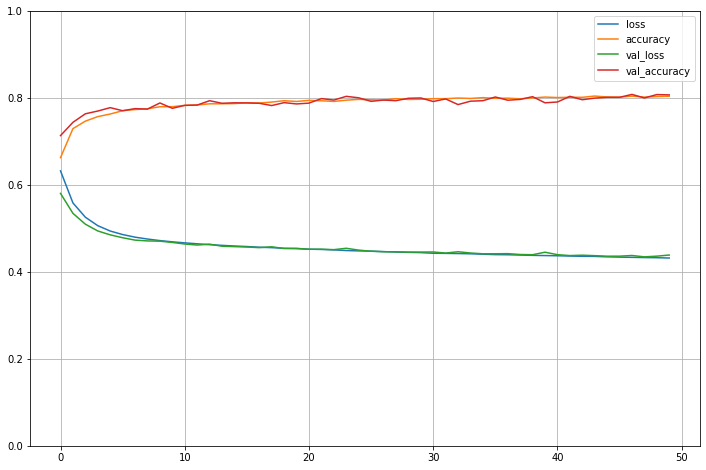

In [77]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [78]:
# Make class label predictions on the test set using the best model
test_y_pred = (model.predict(X_test) > 0.5).astype("int32")
train_y_pred = (model.predict(X_train) > 0.5).astype("int32")

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

421/421 [==============================] - 0s 1ms/step
Test Model Recall: 0.64

Train Model Recall: 0.71

Test Model Precision: 0.63

Train Model Precision: 0.75



96/96 [==============================] - 0s 1ms/step


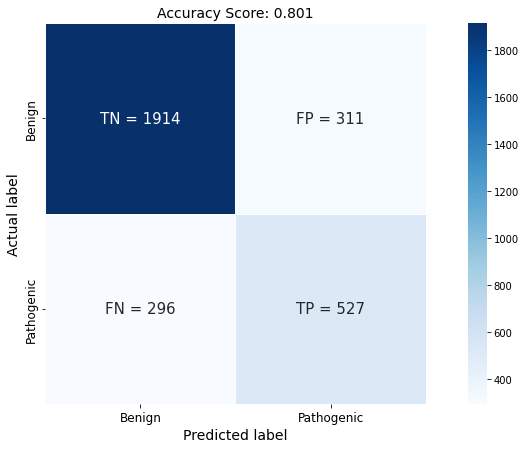

In [79]:
# Generate binary predictions from the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
# Generate a confusion matrix using true labels first, then predictions
cm = metrics.confusion_matrix(y_test, y_pred)
#compute accuracy:
score = model.evaluate(X_test, y_test, verbose=0)[1]

# Prepare a modified confusion matrix for display
modified_cm = []
for index, value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

# Plot the confusion matrix
plt.figure(figsize=(15, 7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square=True,
            cmap='Blues',
            xticklabels=['Benign', 'Pathogenic'],
            yticklabels=['Benign', 'Pathogenic'])
plt.ylabel('Actual label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title('Accuracy Score: {:.3f}'.format(score), size=14)
plt.tick_params(labelsize=12)
plt.show()

In [80]:
# Define a function to build the model
def build_model(optimizer='adam', learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(Dense(32, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(16, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    # Create the optimizer instance using the learning rate:
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")
    
    model.compile(loss="binary_crossentropy",
                  optimizer=opt,
                  metrics=["accuracy"])
    return model

# Wrap the model with KerasClassifier (using scikeras)
model_wrapper = KerasClassifier(model=build_model, verbose=0)

# Define the hyperparameters for random search
params = dict(model__optimizer=["sgd", "adam"], 
              model__learning_rate=[0.001, 0.015, 0.01],
              batch_size=[8, 16, 32],
              epochs=[50, 100, 150],
              model__activation=["relu", "tanh"])

# Set up early stopping and model checkpointing
monitor_val_acc = EarlyStopping(monitor="val_accuracy", patience=10, mode="max")
model_checkpoint = ModelCheckpoint("./best_banknote_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Perform random search using extra fit parameters with the "fit__" prefix
random_search = RandomizedSearchCV(estimator=model_wrapper, param_distributions=params, n_iter=10, cv=3)
h_callback = random_search.fit(X_train, y_train, 
             callbacks=[monitor_val_acc, model_checkpoint],
             validation_split=0.2, verbose=2)

Epoch 1/150
225/225 - 1s - loss: 0.5408 - accuracy: 0.7243 - val_loss: 0.4750 - val_accuracy: 0.7733 - 1s/epoch - 5ms/step
Epoch 2/150
225/225 - 0s - loss: 0.4750 - accuracy: 0.7727 - val_loss: 0.4853 - val_accuracy: 0.7655 - 355ms/epoch - 2ms/step
Epoch 3/150
225/225 - 0s - loss: 0.4617 - accuracy: 0.7817 - val_loss: 0.4875 - val_accuracy: 0.7599 - 371ms/epoch - 2ms/step
Epoch 4/150
225/225 - 0s - loss: 0.4519 - accuracy: 0.7908 - val_loss: 0.4427 - val_accuracy: 0.7955 - 333ms/epoch - 1ms/step
Epoch 5/150
225/225 - 0s - loss: 0.4454 - accuracy: 0.7965 - val_loss: 0.4362 - val_accuracy: 0.7972 - 367ms/epoch - 2ms/step
Epoch 6/150
225/225 - 0s - loss: 0.4425 - accuracy: 0.7984 - val_loss: 0.4434 - val_accuracy: 0.7933 - 351ms/epoch - 2ms/step
Epoch 7/150
225/225 - 0s - loss: 0.4398 - accuracy: 0.7943 - val_loss: 0.4464 - val_accuracy: 0.7916 - 352ms/epoch - 2ms/step
Epoch 8/150
225/225 - 0s - loss: 0.4333 - accuracy: 0.8025 - val_loss: 0.4317 - val_accuracy: 0.7983 - 397ms/epoch - 2ms/

Epoch 66/150
225/225 - 0s - loss: 0.3470 - accuracy: 0.8441 - val_loss: 0.4011 - val_accuracy: 0.8150 - 329ms/epoch - 1ms/step
Epoch 67/150
225/225 - 0s - loss: 0.3478 - accuracy: 0.8411 - val_loss: 0.4595 - val_accuracy: 0.7883 - 327ms/epoch - 1ms/step
Epoch 68/150
225/225 - 0s - loss: 0.3448 - accuracy: 0.8444 - val_loss: 0.3916 - val_accuracy: 0.8262 - 344ms/epoch - 2ms/step
Epoch 69/150
225/225 - 0s - loss: 0.3418 - accuracy: 0.8478 - val_loss: 0.3931 - val_accuracy: 0.8228 - 343ms/epoch - 2ms/step
Epoch 70/150
225/225 - 0s - loss: 0.3425 - accuracy: 0.8430 - val_loss: 0.4261 - val_accuracy: 0.8123 - 344ms/epoch - 2ms/step
Epoch 71/150
225/225 - 0s - loss: 0.3411 - accuracy: 0.8459 - val_loss: 0.4208 - val_accuracy: 0.8128 - 347ms/epoch - 2ms/step
Epoch 72/150
225/225 - 0s - loss: 0.3365 - accuracy: 0.8487 - val_loss: 0.5168 - val_accuracy: 0.7565 - 357ms/epoch - 2ms/step
Epoch 73/150
225/225 - 0s - loss: 0.3361 - accuracy: 0.8486 - val_loss: 0.3927 - val_accuracy: 0.8201 - 360ms/e

Epoch 131/150
225/225 - 0s - loss: 0.2684 - accuracy: 0.8816 - val_loss: 0.4197 - val_accuracy: 0.8273 - 364ms/epoch - 2ms/step
Epoch 132/150
225/225 - 0s - loss: 0.2657 - accuracy: 0.8815 - val_loss: 0.4451 - val_accuracy: 0.8117 - 344ms/epoch - 2ms/step
Epoch 133/150
225/225 - 0s - loss: 0.2684 - accuracy: 0.8823 - val_loss: 0.4337 - val_accuracy: 0.8206 - 347ms/epoch - 2ms/step
Epoch 134/150
225/225 - 0s - loss: 0.2674 - accuracy: 0.8822 - val_loss: 0.5817 - val_accuracy: 0.7543 - 341ms/epoch - 2ms/step
Epoch 135/150
225/225 - 0s - loss: 0.2639 - accuracy: 0.8834 - val_loss: 0.4299 - val_accuracy: 0.8195 - 339ms/epoch - 2ms/step
Epoch 136/150
225/225 - 0s - loss: 0.2662 - accuracy: 0.8833 - val_loss: 0.4341 - val_accuracy: 0.8206 - 327ms/epoch - 1ms/step
Epoch 137/150
225/225 - 0s - loss: 0.2619 - accuracy: 0.8820 - val_loss: 0.4740 - val_accuracy: 0.8173 - 340ms/epoch - 2ms/step
Epoch 138/150
225/225 - 0s - loss: 0.2572 - accuracy: 0.8881 - val_loss: 0.5219 - val_accuracy: 0.8050 -

Epoch 46/150
225/225 - 0s - loss: 0.3803 - accuracy: 0.8320 - val_loss: 0.4298 - val_accuracy: 0.8056 - 335ms/epoch - 1ms/step
Epoch 47/150
225/225 - 0s - loss: 0.3788 - accuracy: 0.8299 - val_loss: 0.4477 - val_accuracy: 0.7894 - 342ms/epoch - 2ms/step
Epoch 48/150
225/225 - 0s - loss: 0.3799 - accuracy: 0.8276 - val_loss: 0.4044 - val_accuracy: 0.8128 - 362ms/epoch - 2ms/step
Epoch 49/150
225/225 - 0s - loss: 0.3775 - accuracy: 0.8294 - val_loss: 0.4131 - val_accuracy: 0.8095 - 341ms/epoch - 2ms/step
Epoch 50/150
225/225 - 0s - loss: 0.3761 - accuracy: 0.8326 - val_loss: 0.4151 - val_accuracy: 0.8111 - 365ms/epoch - 2ms/step
Epoch 51/150
225/225 - 0s - loss: 0.3741 - accuracy: 0.8301 - val_loss: 0.4192 - val_accuracy: 0.7983 - 337ms/epoch - 1ms/step
Epoch 52/150
225/225 - 0s - loss: 0.3733 - accuracy: 0.8352 - val_loss: 0.4542 - val_accuracy: 0.7738 - 349ms/epoch - 2ms/step
Epoch 53/150
225/225 - 0s - loss: 0.3723 - accuracy: 0.8333 - val_loss: 0.4111 - val_accuracy: 0.8123 - 359ms/e

Epoch 111/150
225/225 - 0s - loss: 0.2964 - accuracy: 0.8643 - val_loss: 0.4296 - val_accuracy: 0.8067 - 340ms/epoch - 2ms/step
Epoch 112/150
225/225 - 0s - loss: 0.2972 - accuracy: 0.8716 - val_loss: 0.4320 - val_accuracy: 0.8095 - 330ms/epoch - 1ms/step
Epoch 113/150
225/225 - 0s - loss: 0.2961 - accuracy: 0.8685 - val_loss: 0.4364 - val_accuracy: 0.8212 - 358ms/epoch - 2ms/step
Epoch 114/150
225/225 - 0s - loss: 0.2953 - accuracy: 0.8682 - val_loss: 0.4652 - val_accuracy: 0.7994 - 333ms/epoch - 1ms/step
Epoch 115/150
225/225 - 0s - loss: 0.2955 - accuracy: 0.8703 - val_loss: 0.4756 - val_accuracy: 0.8006 - 330ms/epoch - 1ms/step
Epoch 116/150
225/225 - 0s - loss: 0.2876 - accuracy: 0.8723 - val_loss: 0.4312 - val_accuracy: 0.8123 - 359ms/epoch - 2ms/step
Epoch 117/150
225/225 - 0s - loss: 0.2885 - accuracy: 0.8763 - val_loss: 0.4370 - val_accuracy: 0.8128 - 328ms/epoch - 1ms/step
Epoch 118/150
225/225 - 0s - loss: 0.2854 - accuracy: 0.8745 - val_loss: 0.4279 - val_accuracy: 0.8234 -

Epoch 26/150
225/225 - 0s - loss: 0.4094 - accuracy: 0.8071 - val_loss: 0.4283 - val_accuracy: 0.7972 - 343ms/epoch - 2ms/step
Epoch 27/150
225/225 - 0s - loss: 0.4086 - accuracy: 0.8107 - val_loss: 0.4148 - val_accuracy: 0.8050 - 362ms/epoch - 2ms/step
Epoch 28/150
225/225 - 0s - loss: 0.4078 - accuracy: 0.8093 - val_loss: 0.4107 - val_accuracy: 0.8117 - 357ms/epoch - 2ms/step
Epoch 29/150
225/225 - 0s - loss: 0.4045 - accuracy: 0.8153 - val_loss: 0.4562 - val_accuracy: 0.7777 - 360ms/epoch - 2ms/step
Epoch 30/150
225/225 - 0s - loss: 0.4068 - accuracy: 0.8128 - val_loss: 0.4377 - val_accuracy: 0.7961 - 335ms/epoch - 1ms/step
Epoch 31/150
225/225 - 0s - loss: 0.4040 - accuracy: 0.8117 - val_loss: 0.4105 - val_accuracy: 0.8095 - 314ms/epoch - 1ms/step
Epoch 32/150
225/225 - 0s - loss: 0.4012 - accuracy: 0.8164 - val_loss: 0.4284 - val_accuracy: 0.8006 - 344ms/epoch - 2ms/step
Epoch 33/150
225/225 - 0s - loss: 0.4018 - accuracy: 0.8161 - val_loss: 0.4327 - val_accuracy: 0.7933 - 329ms/e

Epoch 91/150
225/225 - 0s - loss: 0.3363 - accuracy: 0.8471 - val_loss: 0.3962 - val_accuracy: 0.8167 - 345ms/epoch - 2ms/step
Epoch 92/150
225/225 - 0s - loss: 0.3351 - accuracy: 0.8543 - val_loss: 0.4088 - val_accuracy: 0.8089 - 348ms/epoch - 2ms/step
Epoch 93/150
225/225 - 0s - loss: 0.3313 - accuracy: 0.8539 - val_loss: 0.4047 - val_accuracy: 0.8156 - 327ms/epoch - 1ms/step
Epoch 94/150
225/225 - 0s - loss: 0.3300 - accuracy: 0.8543 - val_loss: 0.7573 - val_accuracy: 0.7042 - 356ms/epoch - 2ms/step
Epoch 95/150
225/225 - 0s - loss: 0.3298 - accuracy: 0.8518 - val_loss: 0.3943 - val_accuracy: 0.8240 - 321ms/epoch - 1ms/step
Epoch 96/150
225/225 - 0s - loss: 0.3261 - accuracy: 0.8547 - val_loss: 0.3914 - val_accuracy: 0.8262 - 332ms/epoch - 1ms/step
Epoch 97/150
225/225 - 0s - loss: 0.3250 - accuracy: 0.8551 - val_loss: 0.3915 - val_accuracy: 0.8273 - 359ms/epoch - 2ms/step
Epoch 98/150
225/225 - 0s - loss: 0.3220 - accuracy: 0.8593 - val_loss: 0.4037 - val_accuracy: 0.8195 - 341ms/e

Epoch 6/50
225/225 - 0s - loss: 0.5126 - accuracy: 0.7505 - val_loss: 0.4894 - val_accuracy: 0.7231 - 373ms/epoch - 2ms/step
Epoch 7/50
225/225 - 0s - loss: 0.5083 - accuracy: 0.7504 - val_loss: 0.4989 - val_accuracy: 0.7666 - 364ms/epoch - 2ms/step
Epoch 8/50
225/225 - 0s - loss: 0.5185 - accuracy: 0.7558 - val_loss: 0.5705 - val_accuracy: 0.7443 - 359ms/epoch - 2ms/step
Epoch 9/50
225/225 - 0s - loss: 0.5436 - accuracy: 0.7261 - val_loss: 0.6020 - val_accuracy: 0.6618 - 367ms/epoch - 2ms/step
Epoch 10/50
225/225 - 0s - loss: 0.5163 - accuracy: 0.7436 - val_loss: 0.5521 - val_accuracy: 0.7309 - 353ms/epoch - 2ms/step
Epoch 11/50
225/225 - 0s - loss: 0.5527 - accuracy: 0.7225 - val_loss: 0.5785 - val_accuracy: 0.6540 - 366ms/epoch - 2ms/step
Epoch 12/50
225/225 - 0s - loss: 0.5483 - accuracy: 0.7282 - val_loss: 0.5626 - val_accuracy: 0.6546 - 359ms/epoch - 2ms/step
Epoch 13/50
225/225 - 0s - loss: 0.5417 - accuracy: 0.7324 - val_loss: 0.5341 - val_accuracy: 0.7565 - 378ms/epoch - 2ms/s

Epoch 22/50
225/225 - 0s - loss: 0.5812 - accuracy: 0.6505 - val_loss: 0.6110 - val_accuracy: 0.6390 - 328ms/epoch - 1ms/step
Epoch 23/50
225/225 - 0s - loss: 0.5751 - accuracy: 0.6761 - val_loss: 0.5234 - val_accuracy: 0.7554 - 349ms/epoch - 2ms/step
Epoch 24/50
225/225 - 0s - loss: 0.5762 - accuracy: 0.7000 - val_loss: 0.6446 - val_accuracy: 0.6719 - 351ms/epoch - 2ms/step
Epoch 25/50
225/225 - 0s - loss: 0.6106 - accuracy: 0.6874 - val_loss: 0.5610 - val_accuracy: 0.7504 - 345ms/epoch - 2ms/step
Epoch 26/50
225/225 - 0s - loss: 0.5607 - accuracy: 0.7078 - val_loss: 0.5620 - val_accuracy: 0.7125 - 378ms/epoch - 2ms/step
Epoch 27/50
225/225 - 0s - loss: 0.5573 - accuracy: 0.7324 - val_loss: 0.5522 - val_accuracy: 0.7577 - 337ms/epoch - 1ms/step
Epoch 28/50
225/225 - 0s - loss: 0.5588 - accuracy: 0.7241 - val_loss: 0.5561 - val_accuracy: 0.7532 - 378ms/epoch - 2ms/step
Epoch 29/50
225/225 - 0s - loss: 0.5551 - accuracy: 0.7320 - val_loss: 0.5314 - val_accuracy: 0.7304 - 361ms/epoch - 2

Epoch 38/50
225/225 - 0s - loss: 0.5523 - accuracy: 0.7278 - val_loss: 0.5251 - val_accuracy: 0.7543 - 343ms/epoch - 2ms/step
Epoch 39/50
225/225 - 0s - loss: 0.5448 - accuracy: 0.7331 - val_loss: 0.5434 - val_accuracy: 0.7476 - 439ms/epoch - 2ms/step
Epoch 40/50
225/225 - 0s - loss: 0.5280 - accuracy: 0.7397 - val_loss: 0.5237 - val_accuracy: 0.7226 - 372ms/epoch - 2ms/step
Epoch 41/50
225/225 - 0s - loss: 0.5354 - accuracy: 0.7287 - val_loss: 0.5725 - val_accuracy: 0.7253 - 349ms/epoch - 2ms/step
Epoch 42/50
225/225 - 0s - loss: 0.5387 - accuracy: 0.7228 - val_loss: 0.5319 - val_accuracy: 0.7003 - 370ms/epoch - 2ms/step
Epoch 43/50
225/225 - 0s - loss: 0.5294 - accuracy: 0.7341 - val_loss: 0.5292 - val_accuracy: 0.6942 - 375ms/epoch - 2ms/step
Epoch 44/50
225/225 - 0s - loss: 0.5236 - accuracy: 0.7511 - val_loss: 0.5151 - val_accuracy: 0.7354 - 351ms/epoch - 2ms/step
Epoch 45/50
225/225 - 0s - loss: 0.5304 - accuracy: 0.7246 - val_loss: 0.5580 - val_accuracy: 0.7304 - 373ms/epoch - 2

Epoch 53/100
225/225 - 0s - loss: 0.2503 - accuracy: 0.8962 - val_loss: 0.4207 - val_accuracy: 0.8223 - 359ms/epoch - 2ms/step
Epoch 54/100
225/225 - 0s - loss: 0.2468 - accuracy: 0.8953 - val_loss: 0.4255 - val_accuracy: 0.8117 - 346ms/epoch - 2ms/step
Epoch 55/100
225/225 - 0s - loss: 0.2421 - accuracy: 0.8978 - val_loss: 0.4250 - val_accuracy: 0.8279 - 366ms/epoch - 2ms/step
Epoch 56/100
225/225 - 0s - loss: 0.2443 - accuracy: 0.8965 - val_loss: 0.4358 - val_accuracy: 0.8128 - 374ms/epoch - 2ms/step
Epoch 57/100
225/225 - 0s - loss: 0.2423 - accuracy: 0.8986 - val_loss: 0.4323 - val_accuracy: 0.8184 - 366ms/epoch - 2ms/step
Epoch 58/100
225/225 - 0s - loss: 0.2362 - accuracy: 0.9024 - val_loss: 0.4394 - val_accuracy: 0.8162 - 374ms/epoch - 2ms/step
Epoch 59/100
225/225 - 0s - loss: 0.2294 - accuracy: 0.9054 - val_loss: 0.4470 - val_accuracy: 0.8201 - 380ms/epoch - 2ms/step
Epoch 60/100
225/225 - 0s - loss: 0.2344 - accuracy: 0.9008 - val_loss: 0.4496 - val_accuracy: 0.8240 - 364ms/e

Epoch 18/100
225/225 - 0s - loss: 0.3889 - accuracy: 0.8189 - val_loss: 0.4037 - val_accuracy: 0.8178 - 376ms/epoch - 2ms/step
Epoch 19/100
225/225 - 0s - loss: 0.3854 - accuracy: 0.8195 - val_loss: 0.4047 - val_accuracy: 0.8095 - 356ms/epoch - 2ms/step
Epoch 20/100
225/225 - 0s - loss: 0.3793 - accuracy: 0.8273 - val_loss: 0.4309 - val_accuracy: 0.8078 - 377ms/epoch - 2ms/step
Epoch 21/100
225/225 - 0s - loss: 0.3808 - accuracy: 0.8263 - val_loss: 0.4081 - val_accuracy: 0.8078 - 389ms/epoch - 2ms/step
Epoch 22/100
225/225 - 0s - loss: 0.3737 - accuracy: 0.8292 - val_loss: 0.4075 - val_accuracy: 0.8078 - 422ms/epoch - 2ms/step
Epoch 23/100
225/225 - 0s - loss: 0.3711 - accuracy: 0.8273 - val_loss: 0.4105 - val_accuracy: 0.8089 - 444ms/epoch - 2ms/step
Epoch 24/100
225/225 - 0s - loss: 0.3683 - accuracy: 0.8324 - val_loss: 0.4133 - val_accuracy: 0.8078 - 417ms/epoch - 2ms/step
Epoch 25/100
225/225 - 0s - loss: 0.3636 - accuracy: 0.8349 - val_loss: 0.4091 - val_accuracy: 0.8011 - 390ms/e

Epoch 83/100
225/225 - 0s - loss: 0.2123 - accuracy: 0.9129 - val_loss: 0.4836 - val_accuracy: 0.8006 - 361ms/epoch - 2ms/step
Epoch 84/100
225/225 - 0s - loss: 0.2120 - accuracy: 0.9146 - val_loss: 0.5011 - val_accuracy: 0.7967 - 410ms/epoch - 2ms/step
Epoch 85/100
225/225 - 0s - loss: 0.2071 - accuracy: 0.9177 - val_loss: 0.5243 - val_accuracy: 0.7877 - 400ms/epoch - 2ms/step
Epoch 86/100
225/225 - 0s - loss: 0.2104 - accuracy: 0.9121 - val_loss: 0.4998 - val_accuracy: 0.8000 - 362ms/epoch - 2ms/step
Epoch 87/100
225/225 - 0s - loss: 0.2059 - accuracy: 0.9152 - val_loss: 0.5100 - val_accuracy: 0.7989 - 356ms/epoch - 2ms/step
Epoch 88/100
225/225 - 0s - loss: 0.2023 - accuracy: 0.9193 - val_loss: 0.5022 - val_accuracy: 0.8022 - 364ms/epoch - 2ms/step
Epoch 89/100
225/225 - 0s - loss: 0.2002 - accuracy: 0.9200 - val_loss: 0.5103 - val_accuracy: 0.8033 - 372ms/epoch - 2ms/step
Epoch 90/100
225/225 - 0s - loss: 0.2004 - accuracy: 0.9188 - val_loss: 0.5091 - val_accuracy: 0.7972 - 368ms/e

Epoch 48/100
225/225 - 0s - loss: 0.2843 - accuracy: 0.8799 - val_loss: 0.4203 - val_accuracy: 0.8184 - 360ms/epoch - 2ms/step
Epoch 49/100
225/225 - 0s - loss: 0.2822 - accuracy: 0.8755 - val_loss: 0.4157 - val_accuracy: 0.8312 - 354ms/epoch - 2ms/step
Epoch 50/100
225/225 - 0s - loss: 0.2764 - accuracy: 0.8824 - val_loss: 0.4154 - val_accuracy: 0.8273 - 353ms/epoch - 2ms/step
Epoch 51/100
225/225 - 0s - loss: 0.2739 - accuracy: 0.8810 - val_loss: 0.4231 - val_accuracy: 0.8245 - 359ms/epoch - 2ms/step
Epoch 52/100
225/225 - 0s - loss: 0.2735 - accuracy: 0.8849 - val_loss: 0.4110 - val_accuracy: 0.8362 - 369ms/epoch - 2ms/step
Epoch 53/100
225/225 - 0s - loss: 0.2671 - accuracy: 0.8874 - val_loss: 0.4234 - val_accuracy: 0.8156 - 374ms/epoch - 2ms/step
Epoch 54/100
225/225 - 0s - loss: 0.2627 - accuracy: 0.8876 - val_loss: 0.4180 - val_accuracy: 0.8306 - 466ms/epoch - 2ms/step
Epoch 55/100
225/225 - 0s - loss: 0.2590 - accuracy: 0.8902 - val_loss: 0.4183 - val_accuracy: 0.8368 - 376ms/e

Epoch 13/100
225/225 - 0s - loss: 0.4327 - accuracy: 0.7997 - val_loss: 0.4448 - val_accuracy: 0.7760 - 353ms/epoch - 2ms/step
Epoch 14/100
225/225 - 0s - loss: 0.4326 - accuracy: 0.8042 - val_loss: 0.4230 - val_accuracy: 0.7961 - 389ms/epoch - 2ms/step
Epoch 15/100
225/225 - 0s - loss: 0.4294 - accuracy: 0.8036 - val_loss: 0.4193 - val_accuracy: 0.8006 - 353ms/epoch - 2ms/step
Epoch 16/100
225/225 - 0s - loss: 0.4201 - accuracy: 0.8079 - val_loss: 0.4298 - val_accuracy: 0.7944 - 360ms/epoch - 2ms/step
Epoch 17/100
225/225 - 0s - loss: 0.4263 - accuracy: 0.8014 - val_loss: 0.4311 - val_accuracy: 0.8022 - 418ms/epoch - 2ms/step
Epoch 18/100
225/225 - 0s - loss: 0.4179 - accuracy: 0.8087 - val_loss: 0.4336 - val_accuracy: 0.8022 - 421ms/epoch - 2ms/step
Epoch 19/100
225/225 - 0s - loss: 0.4282 - accuracy: 0.8030 - val_loss: 0.4572 - val_accuracy: 0.7766 - 366ms/epoch - 2ms/step
Epoch 20/100
225/225 - 0s - loss: 0.4348 - accuracy: 0.8037 - val_loss: 0.4292 - val_accuracy: 0.8050 - 360ms/e

Epoch 78/100
225/225 - 0s - loss: 0.3676 - accuracy: 0.8333 - val_loss: 0.4362 - val_accuracy: 0.8162 - 338ms/epoch - 2ms/step
Epoch 79/100
225/225 - 0s - loss: 0.3723 - accuracy: 0.8292 - val_loss: 0.4465 - val_accuracy: 0.8111 - 362ms/epoch - 2ms/step
Epoch 80/100
225/225 - 0s - loss: 0.3600 - accuracy: 0.8328 - val_loss: 0.4389 - val_accuracy: 0.8056 - 388ms/epoch - 2ms/step
Epoch 81/100
225/225 - 0s - loss: 0.3643 - accuracy: 0.8340 - val_loss: 0.4594 - val_accuracy: 0.8145 - 466ms/epoch - 2ms/step
Epoch 82/100
225/225 - 0s - loss: 0.3725 - accuracy: 0.8301 - val_loss: 0.4459 - val_accuracy: 0.8006 - 396ms/epoch - 2ms/step
Epoch 83/100
225/225 - 0s - loss: 0.3715 - accuracy: 0.8310 - val_loss: 0.4400 - val_accuracy: 0.8117 - 372ms/epoch - 2ms/step
Epoch 84/100
225/225 - 0s - loss: 0.3701 - accuracy: 0.8308 - val_loss: 0.4289 - val_accuracy: 0.8100 - 363ms/epoch - 2ms/step
Epoch 85/100
225/225 - 0s - loss: 0.3745 - accuracy: 0.8302 - val_loss: 0.4400 - val_accuracy: 0.8056 - 369ms/e

Epoch 43/100
225/225 - 0s - loss: 0.4100 - accuracy: 0.8062 - val_loss: 0.4140 - val_accuracy: 0.8017 - 391ms/epoch - 2ms/step
Epoch 44/100
225/225 - 0s - loss: 0.4063 - accuracy: 0.8078 - val_loss: 0.4213 - val_accuracy: 0.8033 - 384ms/epoch - 2ms/step
Epoch 45/100
225/225 - 0s - loss: 0.4092 - accuracy: 0.8075 - val_loss: 0.4191 - val_accuracy: 0.7944 - 345ms/epoch - 2ms/step
Epoch 46/100
225/225 - 0s - loss: 0.4041 - accuracy: 0.8097 - val_loss: 0.4298 - val_accuracy: 0.7933 - 366ms/epoch - 2ms/step
Epoch 47/100
225/225 - 0s - loss: 0.4021 - accuracy: 0.8118 - val_loss: 0.4085 - val_accuracy: 0.8089 - 341ms/epoch - 2ms/step
Epoch 48/100
225/225 - 0s - loss: 0.3967 - accuracy: 0.8164 - val_loss: 0.4179 - val_accuracy: 0.8084 - 380ms/epoch - 2ms/step
Epoch 49/100
225/225 - 0s - loss: 0.4085 - accuracy: 0.8126 - val_loss: 0.4257 - val_accuracy: 0.7994 - 418ms/epoch - 2ms/step
Epoch 50/100
225/225 - 0s - loss: 0.4092 - accuracy: 0.8092 - val_loss: 0.4052 - val_accuracy: 0.8184 - 365ms/e

Epoch 8/100
225/225 - 0s - loss: 0.4426 - accuracy: 0.7913 - val_loss: 0.4230 - val_accuracy: 0.8006 - 377ms/epoch - 2ms/step
Epoch 9/100
225/225 - 0s - loss: 0.4431 - accuracy: 0.7912 - val_loss: 0.4411 - val_accuracy: 0.7838 - 389ms/epoch - 2ms/step
Epoch 10/100
225/225 - 0s - loss: 0.4439 - accuracy: 0.7908 - val_loss: 0.4415 - val_accuracy: 0.7894 - 370ms/epoch - 2ms/step
Epoch 11/100
225/225 - 0s - loss: 0.4384 - accuracy: 0.7892 - val_loss: 0.4265 - val_accuracy: 0.7944 - 367ms/epoch - 2ms/step
Epoch 12/100
225/225 - 0s - loss: 0.4367 - accuracy: 0.7975 - val_loss: 0.4239 - val_accuracy: 0.8095 - 374ms/epoch - 2ms/step
Epoch 13/100
225/225 - 0s - loss: 0.4319 - accuracy: 0.7959 - val_loss: 0.4490 - val_accuracy: 0.7788 - 365ms/epoch - 2ms/step
Epoch 14/100
225/225 - 0s - loss: 0.4348 - accuracy: 0.7993 - val_loss: 0.4285 - val_accuracy: 0.8050 - 344ms/epoch - 2ms/step
Epoch 15/100
225/225 - 0s - loss: 0.4307 - accuracy: 0.8018 - val_loss: 0.4561 - val_accuracy: 0.7833 - 348ms/epo

Epoch 73/100
225/225 - 0s - loss: 0.3887 - accuracy: 0.8185 - val_loss: 0.4195 - val_accuracy: 0.8156 - 379ms/epoch - 2ms/step
Epoch 74/100
225/225 - 0s - loss: 0.3880 - accuracy: 0.8184 - val_loss: 0.4188 - val_accuracy: 0.8078 - 377ms/epoch - 2ms/step
Epoch 75/100
225/225 - 0s - loss: 0.3886 - accuracy: 0.8202 - val_loss: 0.4116 - val_accuracy: 0.8156 - 344ms/epoch - 2ms/step
Epoch 76/100
225/225 - 0s - loss: 0.3903 - accuracy: 0.8200 - val_loss: 0.4211 - val_accuracy: 0.8072 - 378ms/epoch - 2ms/step
Epoch 77/100
225/225 - 0s - loss: 0.3807 - accuracy: 0.8225 - val_loss: 0.4195 - val_accuracy: 0.8217 - 450ms/epoch - 2ms/step
Epoch 78/100
225/225 - 0s - loss: 0.3880 - accuracy: 0.8284 - val_loss: 0.4222 - val_accuracy: 0.8217 - 387ms/epoch - 2ms/step
Epoch 79/100
225/225 - 0s - loss: 0.3950 - accuracy: 0.8184 - val_loss: 0.4321 - val_accuracy: 0.8033 - 375ms/epoch - 2ms/step
Epoch 80/100
225/225 - 0s - loss: 0.3830 - accuracy: 0.8266 - val_loss: 0.4268 - val_accuracy: 0.8123 - 443ms/e

Epoch 38/150
449/449 - 1s - loss: 0.4344 - accuracy: 0.7997 - val_loss: 0.4383 - val_accuracy: 0.7978 - 607ms/epoch - 1ms/step
Epoch 39/150
449/449 - 1s - loss: 0.4340 - accuracy: 0.8007 - val_loss: 0.4377 - val_accuracy: 0.7983 - 727ms/epoch - 2ms/step
Epoch 40/150
449/449 - 1s - loss: 0.4332 - accuracy: 0.8005 - val_loss: 0.4377 - val_accuracy: 0.7989 - 687ms/epoch - 2ms/step
Epoch 41/150
449/449 - 1s - loss: 0.4320 - accuracy: 0.8018 - val_loss: 0.4358 - val_accuracy: 0.8017 - 677ms/epoch - 2ms/step
Epoch 42/150
449/449 - 1s - loss: 0.4306 - accuracy: 0.7993 - val_loss: 0.4398 - val_accuracy: 0.7972 - 652ms/epoch - 1ms/step
Epoch 43/150
449/449 - 1s - loss: 0.4304 - accuracy: 0.8039 - val_loss: 0.4369 - val_accuracy: 0.7955 - 626ms/epoch - 1ms/step
Epoch 44/150
449/449 - 1s - loss: 0.4297 - accuracy: 0.8023 - val_loss: 0.4366 - val_accuracy: 0.7955 - 761ms/epoch - 2ms/step
Epoch 45/150
449/449 - 1s - loss: 0.4292 - accuracy: 0.8012 - val_loss: 0.4347 - val_accuracy: 0.8006 - 642ms/e

Epoch 103/150
449/449 - 1s - loss: 0.3984 - accuracy: 0.8174 - val_loss: 0.4238 - val_accuracy: 0.8011 - 616ms/epoch - 1ms/step
Epoch 104/150
449/449 - 1s - loss: 0.3977 - accuracy: 0.8198 - val_loss: 0.4261 - val_accuracy: 0.8050 - 693ms/epoch - 2ms/step
Epoch 105/150
449/449 - 1s - loss: 0.3978 - accuracy: 0.8175 - val_loss: 0.4221 - val_accuracy: 0.8084 - 660ms/epoch - 1ms/step
Epoch 106/150
449/449 - 1s - loss: 0.3977 - accuracy: 0.8174 - val_loss: 0.4252 - val_accuracy: 0.7983 - 622ms/epoch - 1ms/step
Epoch 107/150
449/449 - 1s - loss: 0.3973 - accuracy: 0.8211 - val_loss: 0.4231 - val_accuracy: 0.8067 - 603ms/epoch - 1ms/step
Epoch 108/150
449/449 - 1s - loss: 0.3971 - accuracy: 0.8184 - val_loss: 0.4227 - val_accuracy: 0.8061 - 639ms/epoch - 1ms/step
Epoch 109/150
449/449 - 1s - loss: 0.3966 - accuracy: 0.8188 - val_loss: 0.4231 - val_accuracy: 0.8033 - 695ms/epoch - 2ms/step
Epoch 110/150
449/449 - 1s - loss: 0.3958 - accuracy: 0.8203 - val_loss: 0.4239 - val_accuracy: 0.8022 -

Epoch 18/150
449/449 - 1s - loss: 0.4641 - accuracy: 0.7798 - val_loss: 0.4491 - val_accuracy: 0.7844 - 668ms/epoch - 1ms/step
Epoch 19/150
449/449 - 1s - loss: 0.4629 - accuracy: 0.7826 - val_loss: 0.4484 - val_accuracy: 0.7861 - 667ms/epoch - 1ms/step
Epoch 20/150
449/449 - 1s - loss: 0.4612 - accuracy: 0.7841 - val_loss: 0.4468 - val_accuracy: 0.7855 - 603ms/epoch - 1ms/step
Epoch 21/150
449/449 - 1s - loss: 0.4596 - accuracy: 0.7846 - val_loss: 0.4457 - val_accuracy: 0.7827 - 731ms/epoch - 2ms/step
Epoch 22/150
449/449 - 1s - loss: 0.4593 - accuracy: 0.7837 - val_loss: 0.4453 - val_accuracy: 0.7822 - 674ms/epoch - 2ms/step
Epoch 23/150
449/449 - 1s - loss: 0.4576 - accuracy: 0.7865 - val_loss: 0.4438 - val_accuracy: 0.7833 - 655ms/epoch - 1ms/step
Epoch 24/150
449/449 - 1s - loss: 0.4562 - accuracy: 0.7876 - val_loss: 0.4452 - val_accuracy: 0.7822 - 670ms/epoch - 1ms/step
Epoch 25/150
449/449 - 1s - loss: 0.4557 - accuracy: 0.7858 - val_loss: 0.4420 - val_accuracy: 0.7850 - 620ms/e

Epoch 83/150
449/449 - 1s - loss: 0.4187 - accuracy: 0.8079 - val_loss: 0.4179 - val_accuracy: 0.7961 - 644ms/epoch - 1ms/step
Epoch 84/150
449/449 - 1s - loss: 0.4189 - accuracy: 0.8078 - val_loss: 0.4164 - val_accuracy: 0.8022 - 737ms/epoch - 2ms/step
Epoch 85/150
449/449 - 1s - loss: 0.4186 - accuracy: 0.8081 - val_loss: 0.4157 - val_accuracy: 0.8017 - 680ms/epoch - 2ms/step
Epoch 86/150
449/449 - 1s - loss: 0.4182 - accuracy: 0.8100 - val_loss: 0.4164 - val_accuracy: 0.8072 - 647ms/epoch - 1ms/step
Epoch 87/150
449/449 - 1s - loss: 0.4177 - accuracy: 0.8120 - val_loss: 0.4188 - val_accuracy: 0.7961 - 633ms/epoch - 1ms/step
Epoch 88/150
449/449 - 1s - loss: 0.4169 - accuracy: 0.8096 - val_loss: 0.4193 - val_accuracy: 0.8067 - 699ms/epoch - 2ms/step
Epoch 89/150
449/449 - 1s - loss: 0.4168 - accuracy: 0.8096 - val_loss: 0.4159 - val_accuracy: 0.8050 - 686ms/epoch - 2ms/step
Epoch 90/150
449/449 - 1s - loss: 0.4160 - accuracy: 0.8106 - val_loss: 0.4131 - val_accuracy: 0.8072 - 651ms/e

Epoch 148/150
449/449 - 1s - loss: 0.3977 - accuracy: 0.8199 - val_loss: 0.4089 - val_accuracy: 0.8084 - 612ms/epoch - 1ms/step
Epoch 149/150
449/449 - 1s - loss: 0.3968 - accuracy: 0.8216 - val_loss: 0.4112 - val_accuracy: 0.8050 - 720ms/epoch - 2ms/step
Epoch 150/150
449/449 - 1s - loss: 0.3962 - accuracy: 0.8186 - val_loss: 0.4206 - val_accuracy: 0.7983 - 681ms/epoch - 2ms/step
Epoch 1/150
449/449 - 1s - loss: 0.6177 - accuracy: 0.6873 - val_loss: 0.5870 - val_accuracy: 0.7064 - 1s/epoch - 3ms/step
Epoch 2/150
449/449 - 1s - loss: 0.5626 - accuracy: 0.7305 - val_loss: 0.5477 - val_accuracy: 0.7432 - 661ms/epoch - 1ms/step
Epoch 3/150
449/449 - 1s - loss: 0.5306 - accuracy: 0.7512 - val_loss: 0.5207 - val_accuracy: 0.7499 - 662ms/epoch - 1ms/step
Epoch 4/150
449/449 - 1s - loss: 0.5092 - accuracy: 0.7579 - val_loss: 0.5050 - val_accuracy: 0.7532 - 628ms/epoch - 1ms/step
Epoch 5/150
449/449 - 1s - loss: 0.4967 - accuracy: 0.7621 - val_loss: 0.4954 - val_accuracy: 0.7560 - 674ms/epoch 

Epoch 63/150
449/449 - 1s - loss: 0.4320 - accuracy: 0.8012 - val_loss: 0.4330 - val_accuracy: 0.8039 - 634ms/epoch - 1ms/step
Epoch 64/150
449/449 - 1s - loss: 0.4323 - accuracy: 0.8014 - val_loss: 0.4344 - val_accuracy: 0.8056 - 609ms/epoch - 1ms/step
Epoch 65/150
449/449 - 1s - loss: 0.4305 - accuracy: 0.8018 - val_loss: 0.4510 - val_accuracy: 0.7866 - 758ms/epoch - 2ms/step
Epoch 66/150
449/449 - 1s - loss: 0.4311 - accuracy: 0.8014 - val_loss: 0.4307 - val_accuracy: 0.8056 - 651ms/epoch - 1ms/step
Epoch 67/150
449/449 - 1s - loss: 0.4304 - accuracy: 0.8028 - val_loss: 0.4368 - val_accuracy: 0.8006 - 674ms/epoch - 2ms/step
Epoch 68/150
449/449 - 1s - loss: 0.4288 - accuracy: 0.7990 - val_loss: 0.4341 - val_accuracy: 0.8072 - 648ms/epoch - 1ms/step
Epoch 69/150
449/449 - 1s - loss: 0.4298 - accuracy: 0.8046 - val_loss: 0.4289 - val_accuracy: 0.8072 - 665ms/epoch - 1ms/step
Epoch 70/150
449/449 - 1s - loss: 0.4286 - accuracy: 0.8057 - val_loss: 0.4435 - val_accuracy: 0.7933 - 752ms/e

Epoch 128/150
449/449 - 1s - loss: 0.4063 - accuracy: 0.8140 - val_loss: 0.4244 - val_accuracy: 0.8056 - 636ms/epoch - 1ms/step
Epoch 129/150
449/449 - 1s - loss: 0.4063 - accuracy: 0.8132 - val_loss: 0.4161 - val_accuracy: 0.8134 - 693ms/epoch - 2ms/step
Epoch 130/150
449/449 - 1s - loss: 0.4064 - accuracy: 0.8131 - val_loss: 0.4142 - val_accuracy: 0.8217 - 705ms/epoch - 2ms/step
Epoch 131/150
449/449 - 1s - loss: 0.4051 - accuracy: 0.8172 - val_loss: 0.4176 - val_accuracy: 0.8195 - 638ms/epoch - 1ms/step
Epoch 132/150
449/449 - 1s - loss: 0.4055 - accuracy: 0.8124 - val_loss: 0.4159 - val_accuracy: 0.8150 - 653ms/epoch - 1ms/step
Epoch 133/150
449/449 - 1s - loss: 0.4037 - accuracy: 0.8150 - val_loss: 0.4149 - val_accuracy: 0.8206 - 610ms/epoch - 1ms/step
Epoch 134/150
449/449 - 1s - loss: 0.4040 - accuracy: 0.8159 - val_loss: 0.4204 - val_accuracy: 0.8100 - 738ms/epoch - 2ms/step
Epoch 135/150
449/449 - 1s - loss: 0.4046 - accuracy: 0.8145 - val_loss: 0.4227 - val_accuracy: 0.8056 -

Epoch 43/150
449/449 - 1s - loss: 0.2397 - accuracy: 0.8948 - val_loss: 0.5419 - val_accuracy: 0.8006 - 771ms/epoch - 2ms/step
Epoch 44/150
449/449 - 1s - loss: 0.2380 - accuracy: 0.8948 - val_loss: 0.5405 - val_accuracy: 0.8156 - 712ms/epoch - 2ms/step
Epoch 45/150
449/449 - 1s - loss: 0.2300 - accuracy: 0.8982 - val_loss: 0.5949 - val_accuracy: 0.8067 - 701ms/epoch - 2ms/step
Epoch 46/150
449/449 - 1s - loss: 0.2268 - accuracy: 0.9028 - val_loss: 0.6016 - val_accuracy: 0.8011 - 651ms/epoch - 1ms/step
Epoch 47/150
449/449 - 1s - loss: 0.2227 - accuracy: 0.9003 - val_loss: 0.5836 - val_accuracy: 0.8017 - 785ms/epoch - 2ms/step
Epoch 48/150
449/449 - 1s - loss: 0.2280 - accuracy: 0.8992 - val_loss: 0.6030 - val_accuracy: 0.7950 - 732ms/epoch - 2ms/step
Epoch 49/150
449/449 - 1s - loss: 0.2204 - accuracy: 0.9043 - val_loss: 0.5633 - val_accuracy: 0.8139 - 691ms/epoch - 2ms/step
Epoch 50/150
449/449 - 1s - loss: 0.2121 - accuracy: 0.9090 - val_loss: 0.6436 - val_accuracy: 0.8017 - 646ms/e

Epoch 108/150
449/449 - 1s - loss: 0.1015 - accuracy: 0.9579 - val_loss: 1.0921 - val_accuracy: 0.7972 - 664ms/epoch - 1ms/step
Epoch 109/150
449/449 - 1s - loss: 0.1153 - accuracy: 0.9539 - val_loss: 1.0350 - val_accuracy: 0.8039 - 781ms/epoch - 2ms/step
Epoch 110/150
449/449 - 1s - loss: 0.1013 - accuracy: 0.9579 - val_loss: 1.0940 - val_accuracy: 0.8022 - 766ms/epoch - 2ms/step
Epoch 111/150
449/449 - 1s - loss: 0.1078 - accuracy: 0.9575 - val_loss: 1.2075 - val_accuracy: 0.7855 - 768ms/epoch - 2ms/step
Epoch 112/150
449/449 - 1s - loss: 0.1177 - accuracy: 0.9528 - val_loss: 1.0314 - val_accuracy: 0.8028 - 712ms/epoch - 2ms/step
Epoch 113/150
449/449 - 1s - loss: 0.1147 - accuracy: 0.9564 - val_loss: 1.0364 - val_accuracy: 0.8022 - 708ms/epoch - 2ms/step
Epoch 114/150
449/449 - 1s - loss: 0.1043 - accuracy: 0.9565 - val_loss: 1.1961 - val_accuracy: 0.7950 - 696ms/epoch - 2ms/step
Epoch 115/150
449/449 - 1s - loss: 0.1084 - accuracy: 0.9558 - val_loss: 1.1387 - val_accuracy: 0.7967 -

Epoch 23/150
449/449 - 1s - loss: 0.3513 - accuracy: 0.8395 - val_loss: 0.4087 - val_accuracy: 0.8050 - 705ms/epoch - 2ms/step
Epoch 24/150
449/449 - 1s - loss: 0.3478 - accuracy: 0.8455 - val_loss: 0.3853 - val_accuracy: 0.8201 - 757ms/epoch - 2ms/step
Epoch 25/150
449/449 - 1s - loss: 0.3383 - accuracy: 0.8490 - val_loss: 0.4235 - val_accuracy: 0.8017 - 712ms/epoch - 2ms/step
Epoch 26/150
449/449 - 1s - loss: 0.3397 - accuracy: 0.8497 - val_loss: 0.3918 - val_accuracy: 0.8184 - 693ms/epoch - 2ms/step
Epoch 27/150
449/449 - 1s - loss: 0.3326 - accuracy: 0.8497 - val_loss: 0.3894 - val_accuracy: 0.8184 - 692ms/epoch - 2ms/step
Epoch 28/150
449/449 - 1s - loss: 0.3286 - accuracy: 0.8500 - val_loss: 0.4305 - val_accuracy: 0.8045 - 738ms/epoch - 2ms/step
Epoch 29/150
449/449 - 1s - loss: 0.3268 - accuracy: 0.8537 - val_loss: 0.3870 - val_accuracy: 0.8201 - 776ms/epoch - 2ms/step
Epoch 30/150
449/449 - 1s - loss: 0.3198 - accuracy: 0.8562 - val_loss: 0.3884 - val_accuracy: 0.8217 - 708ms/e

Epoch 88/150
449/449 - 1s - loss: 0.1439 - accuracy: 0.9400 - val_loss: 0.6850 - val_accuracy: 0.8145 - 813ms/epoch - 2ms/step
Epoch 89/150
449/449 - 1s - loss: 0.1367 - accuracy: 0.9444 - val_loss: 0.8428 - val_accuracy: 0.7939 - 702ms/epoch - 2ms/step
Epoch 90/150
449/449 - 1s - loss: 0.1488 - accuracy: 0.9368 - val_loss: 0.6951 - val_accuracy: 0.8106 - 707ms/epoch - 2ms/step
Epoch 91/150
449/449 - 1s - loss: 0.1422 - accuracy: 0.9448 - val_loss: 0.7281 - val_accuracy: 0.8111 - 665ms/epoch - 1ms/step
Epoch 92/150
449/449 - 1s - loss: 0.1389 - accuracy: 0.9443 - val_loss: 0.7621 - val_accuracy: 0.8150 - 783ms/epoch - 2ms/step
Epoch 93/150
449/449 - 1s - loss: 0.1332 - accuracy: 0.9465 - val_loss: 0.8017 - val_accuracy: 0.7950 - 700ms/epoch - 2ms/step
Epoch 94/150
449/449 - 1s - loss: 0.1523 - accuracy: 0.9369 - val_loss: 0.7673 - val_accuracy: 0.7944 - 685ms/epoch - 2ms/step
Epoch 95/150
449/449 - 1s - loss: 0.1313 - accuracy: 0.9496 - val_loss: 0.7760 - val_accuracy: 0.8162 - 669ms/e

Epoch 3/150
449/449 - 1s - loss: 0.4479 - accuracy: 0.7897 - val_loss: 0.4526 - val_accuracy: 0.7822 - 696ms/epoch - 2ms/step
Epoch 4/150
449/449 - 1s - loss: 0.4390 - accuracy: 0.7919 - val_loss: 0.4345 - val_accuracy: 0.8011 - 694ms/epoch - 2ms/step
Epoch 5/150
449/449 - 1s - loss: 0.4281 - accuracy: 0.8014 - val_loss: 0.4259 - val_accuracy: 0.8033 - 720ms/epoch - 2ms/step
Epoch 6/150
449/449 - 1s - loss: 0.4216 - accuracy: 0.8069 - val_loss: 0.4181 - val_accuracy: 0.8072 - 682ms/epoch - 2ms/step
Epoch 7/150
449/449 - 1s - loss: 0.4199 - accuracy: 0.8103 - val_loss: 0.4219 - val_accuracy: 0.8045 - 688ms/epoch - 2ms/step
Epoch 8/150
449/449 - 1s - loss: 0.4126 - accuracy: 0.8140 - val_loss: 0.4141 - val_accuracy: 0.8111 - 811ms/epoch - 2ms/step
Epoch 9/150
449/449 - 1s - loss: 0.4088 - accuracy: 0.8142 - val_loss: 0.4155 - val_accuracy: 0.8056 - 713ms/epoch - 2ms/step
Epoch 10/150
449/449 - 1s - loss: 0.4013 - accuracy: 0.8178 - val_loss: 0.4223 - val_accuracy: 0.8056 - 671ms/epoch - 

Epoch 68/150
449/449 - 1s - loss: 0.1569 - accuracy: 0.9324 - val_loss: 0.6712 - val_accuracy: 0.8201 - 707ms/epoch - 2ms/step
Epoch 69/150
449/449 - 1s - loss: 0.1555 - accuracy: 0.9372 - val_loss: 0.6587 - val_accuracy: 0.8106 - 705ms/epoch - 2ms/step
Epoch 70/150
449/449 - 1s - loss: 0.1618 - accuracy: 0.9372 - val_loss: 0.7096 - val_accuracy: 0.8156 - 697ms/epoch - 2ms/step
Epoch 71/150
449/449 - 1s - loss: 0.1649 - accuracy: 0.9320 - val_loss: 0.6519 - val_accuracy: 0.8134 - 799ms/epoch - 2ms/step
Epoch 72/150
449/449 - 1s - loss: 0.1479 - accuracy: 0.9394 - val_loss: 0.7008 - val_accuracy: 0.8123 - 694ms/epoch - 2ms/step
Epoch 73/150
449/449 - 1s - loss: 0.1492 - accuracy: 0.9404 - val_loss: 0.7327 - val_accuracy: 0.8111 - 681ms/epoch - 2ms/step
Epoch 74/150
449/449 - 1s - loss: 0.1535 - accuracy: 0.9395 - val_loss: 0.7236 - val_accuracy: 0.8128 - 661ms/epoch - 1ms/step
Epoch 75/150
449/449 - 1s - loss: 0.1741 - accuracy: 0.9280 - val_loss: 0.7170 - val_accuracy: 0.8212 - 814ms/e

Epoch 133/150
449/449 - 1s - loss: 0.0868 - accuracy: 0.9694 - val_loss: 1.0965 - val_accuracy: 0.8028 - 690ms/epoch - 2ms/step
Epoch 134/150
449/449 - 1s - loss: 0.0664 - accuracy: 0.9745 - val_loss: 1.1643 - val_accuracy: 0.8178 - 779ms/epoch - 2ms/step
Epoch 135/150
449/449 - 1s - loss: 0.0653 - accuracy: 0.9755 - val_loss: 1.1459 - val_accuracy: 0.7961 - 722ms/epoch - 2ms/step
Epoch 136/150
449/449 - 1s - loss: 0.1190 - accuracy: 0.9518 - val_loss: 1.1006 - val_accuracy: 0.7983 - 702ms/epoch - 2ms/step
Epoch 137/150
449/449 - 1s - loss: 0.0655 - accuracy: 0.9737 - val_loss: 1.1663 - val_accuracy: 0.8006 - 675ms/epoch - 2ms/step
Epoch 138/150
449/449 - 1s - loss: 0.0686 - accuracy: 0.9738 - val_loss: 1.1988 - val_accuracy: 0.8017 - 780ms/epoch - 2ms/step
Epoch 139/150
449/449 - 1s - loss: 0.0668 - accuracy: 0.9742 - val_loss: 1.2490 - val_accuracy: 0.8039 - 710ms/epoch - 2ms/step
Epoch 140/150
449/449 - 1s - loss: 0.0884 - accuracy: 0.9674 - val_loss: 1.1831 - val_accuracy: 0.8089 -

Epoch 48/150
449/449 - 1s - loss: 0.3372 - accuracy: 0.8462 - val_loss: 0.4048 - val_accuracy: 0.8078 - 768ms/epoch - 2ms/step
Epoch 49/150
449/449 - 1s - loss: 0.3336 - accuracy: 0.8539 - val_loss: 0.4120 - val_accuracy: 0.8061 - 670ms/epoch - 1ms/step
Epoch 50/150
449/449 - 1s - loss: 0.3351 - accuracy: 0.8490 - val_loss: 0.4073 - val_accuracy: 0.8056 - 652ms/epoch - 1ms/step
Epoch 51/150
449/449 - 1s - loss: 0.3255 - accuracy: 0.8530 - val_loss: 0.4378 - val_accuracy: 0.8045 - 625ms/epoch - 1ms/step
Epoch 52/150
449/449 - 1s - loss: 0.3296 - accuracy: 0.8514 - val_loss: 0.4204 - val_accuracy: 0.8078 - 695ms/epoch - 2ms/step
Epoch 53/150
449/449 - 1s - loss: 0.3302 - accuracy: 0.8476 - val_loss: 0.4527 - val_accuracy: 0.7983 - 694ms/epoch - 2ms/step
Epoch 54/150
449/449 - 1s - loss: 0.3248 - accuracy: 0.8564 - val_loss: 0.4248 - val_accuracy: 0.8061 - 666ms/epoch - 1ms/step
Epoch 55/150
449/449 - 1s - loss: 0.3235 - accuracy: 0.8543 - val_loss: 0.4379 - val_accuracy: 0.8045 - 651ms/e

Epoch 113/150
449/449 - 1s - loss: 0.2333 - accuracy: 0.9004 - val_loss: 0.5078 - val_accuracy: 0.7928 - 763ms/epoch - 2ms/step
Epoch 114/150
449/449 - 1s - loss: 0.2261 - accuracy: 0.9040 - val_loss: 0.5576 - val_accuracy: 0.7827 - 681ms/epoch - 2ms/step
Epoch 115/150
449/449 - 1s - loss: 0.2263 - accuracy: 0.9010 - val_loss: 0.4704 - val_accuracy: 0.8145 - 686ms/epoch - 2ms/step
Epoch 116/150
449/449 - 1s - loss: 0.2363 - accuracy: 0.8985 - val_loss: 0.4886 - val_accuracy: 0.8078 - 713ms/epoch - 2ms/step
Epoch 117/150
449/449 - 1s - loss: 0.2232 - accuracy: 0.9078 - val_loss: 0.4988 - val_accuracy: 0.8134 - 680ms/epoch - 2ms/step
Epoch 118/150
449/449 - 1s - loss: 0.2194 - accuracy: 0.9054 - val_loss: 0.4963 - val_accuracy: 0.8061 - 642ms/epoch - 1ms/step
Epoch 119/150
449/449 - 1s - loss: 0.2219 - accuracy: 0.9089 - val_loss: 0.5210 - val_accuracy: 0.8022 - 874ms/epoch - 2ms/step
Epoch 120/150
449/449 - 1s - loss: 0.2274 - accuracy: 0.9005 - val_loss: 0.4823 - val_accuracy: 0.8028 -

Epoch 28/150
449/449 - 1s - loss: 0.3937 - accuracy: 0.8153 - val_loss: 0.4373 - val_accuracy: 0.7978 - 721ms/epoch - 2ms/step
Epoch 29/150
449/449 - 1s - loss: 0.3930 - accuracy: 0.8174 - val_loss: 0.4101 - val_accuracy: 0.8139 - 820ms/epoch - 2ms/step
Epoch 30/150
449/449 - 1s - loss: 0.3909 - accuracy: 0.8185 - val_loss: 0.4043 - val_accuracy: 0.8111 - 652ms/epoch - 1ms/step
Epoch 31/150
449/449 - 1s - loss: 0.3908 - accuracy: 0.8182 - val_loss: 0.3983 - val_accuracy: 0.8106 - 676ms/epoch - 2ms/step
Epoch 32/150
449/449 - 1s - loss: 0.3871 - accuracy: 0.8191 - val_loss: 0.4114 - val_accuracy: 0.8056 - 752ms/epoch - 2ms/step
Epoch 33/150
449/449 - 1s - loss: 0.3887 - accuracy: 0.8238 - val_loss: 0.4107 - val_accuracy: 0.8111 - 672ms/epoch - 1ms/step
Epoch 34/150
449/449 - 1s - loss: 0.3856 - accuracy: 0.8227 - val_loss: 0.4064 - val_accuracy: 0.8156 - 651ms/epoch - 1ms/step
Epoch 35/150
449/449 - 1s - loss: 0.3856 - accuracy: 0.8193 - val_loss: 0.3946 - val_accuracy: 0.8134 - 631ms/e

Epoch 93/150
449/449 - 1s - loss: 0.2978 - accuracy: 0.8692 - val_loss: 0.4224 - val_accuracy: 0.8117 - 659ms/epoch - 1ms/step
Epoch 94/150
449/449 - 1s - loss: 0.2989 - accuracy: 0.8649 - val_loss: 0.4220 - val_accuracy: 0.8145 - 733ms/epoch - 2ms/step
Epoch 95/150
449/449 - 1s - loss: 0.2924 - accuracy: 0.8689 - val_loss: 0.4161 - val_accuracy: 0.8123 - 694ms/epoch - 2ms/step
Epoch 96/150
449/449 - 1s - loss: 0.2914 - accuracy: 0.8713 - val_loss: 0.4177 - val_accuracy: 0.8061 - 653ms/epoch - 1ms/step
Epoch 97/150
449/449 - 1s - loss: 0.2936 - accuracy: 0.8705 - val_loss: 0.4035 - val_accuracy: 0.8273 - 649ms/epoch - 1ms/step
Epoch 98/150
449/449 - 1s - loss: 0.2949 - accuracy: 0.8660 - val_loss: 0.4162 - val_accuracy: 0.8184 - 646ms/epoch - 1ms/step
Epoch 99/150
449/449 - 1s - loss: 0.2900 - accuracy: 0.8716 - val_loss: 0.4626 - val_accuracy: 0.7928 - 755ms/epoch - 2ms/step
Epoch 100/150
449/449 - 1s - loss: 0.2891 - accuracy: 0.8720 - val_loss: 0.4458 - val_accuracy: 0.8067 - 676ms/

Epoch 8/150
449/449 - 1s - loss: 0.4367 - accuracy: 0.7976 - val_loss: 0.4326 - val_accuracy: 0.8028 - 753ms/epoch - 2ms/step
Epoch 9/150
449/449 - 1s - loss: 0.4325 - accuracy: 0.7987 - val_loss: 0.4381 - val_accuracy: 0.7955 - 697ms/epoch - 2ms/step
Epoch 10/150
449/449 - 1s - loss: 0.4313 - accuracy: 0.8000 - val_loss: 0.4376 - val_accuracy: 0.7933 - 645ms/epoch - 1ms/step
Epoch 11/150
449/449 - 1s - loss: 0.4293 - accuracy: 0.8042 - val_loss: 0.4289 - val_accuracy: 0.8039 - 665ms/epoch - 1ms/step
Epoch 12/150
449/449 - 1s - loss: 0.4256 - accuracy: 0.8042 - val_loss: 0.4328 - val_accuracy: 0.7983 - 643ms/epoch - 1ms/step
Epoch 13/150
449/449 - 1s - loss: 0.4221 - accuracy: 0.8068 - val_loss: 0.4335 - val_accuracy: 0.7983 - 779ms/epoch - 2ms/step
Epoch 14/150
449/449 - 1s - loss: 0.4211 - accuracy: 0.8087 - val_loss: 0.4271 - val_accuracy: 0.8022 - 677ms/epoch - 2ms/step
Epoch 15/150
449/449 - 1s - loss: 0.4194 - accuracy: 0.8067 - val_loss: 0.4362 - val_accuracy: 0.7994 - 660ms/epo

Epoch 73/150
449/449 - 1s - loss: 0.3233 - accuracy: 0.8540 - val_loss: 0.4185 - val_accuracy: 0.8033 - 656ms/epoch - 1ms/step
Epoch 74/150
449/449 - 1s - loss: 0.3238 - accuracy: 0.8535 - val_loss: 0.4422 - val_accuracy: 0.8123 - 637ms/epoch - 1ms/step
Epoch 75/150
449/449 - 1s - loss: 0.3234 - accuracy: 0.8526 - val_loss: 0.4220 - val_accuracy: 0.8017 - 689ms/epoch - 2ms/step
Epoch 76/150
449/449 - 1s - loss: 0.3187 - accuracy: 0.8529 - val_loss: 0.4157 - val_accuracy: 0.8106 - 699ms/epoch - 2ms/step
Epoch 77/150
449/449 - 1s - loss: 0.3166 - accuracy: 0.8569 - val_loss: 0.4114 - val_accuracy: 0.8117 - 691ms/epoch - 2ms/step
Epoch 78/150
449/449 - 1s - loss: 0.3184 - accuracy: 0.8599 - val_loss: 0.4445 - val_accuracy: 0.7861 - 697ms/epoch - 2ms/step
Epoch 79/150
449/449 - 1s - loss: 0.3121 - accuracy: 0.8595 - val_loss: 0.4323 - val_accuracy: 0.8061 - 634ms/epoch - 1ms/step
Epoch 80/150
449/449 - 1s - loss: 0.3124 - accuracy: 0.8599 - val_loss: 0.4320 - val_accuracy: 0.8050 - 750ms/e

Epoch 138/150
449/449 - 1s - loss: 0.2152 - accuracy: 0.9071 - val_loss: 0.5437 - val_accuracy: 0.8067 - 648ms/epoch - 1ms/step
Epoch 139/150
449/449 - 1s - loss: 0.2240 - accuracy: 0.9032 - val_loss: 0.5211 - val_accuracy: 0.8039 - 746ms/epoch - 2ms/step
Epoch 140/150
449/449 - 1s - loss: 0.2226 - accuracy: 0.9063 - val_loss: 0.5428 - val_accuracy: 0.8134 - 706ms/epoch - 2ms/step
Epoch 141/150
449/449 - 1s - loss: 0.2187 - accuracy: 0.9046 - val_loss: 0.5894 - val_accuracy: 0.7944 - 668ms/epoch - 1ms/step
Epoch 142/150
449/449 - 1s - loss: 0.2122 - accuracy: 0.9074 - val_loss: 0.5119 - val_accuracy: 0.8078 - 623ms/epoch - 1ms/step
Epoch 143/150
449/449 - 1s - loss: 0.2123 - accuracy: 0.9127 - val_loss: 0.5793 - val_accuracy: 0.7894 - 655ms/epoch - 1ms/step
Epoch 144/150
449/449 - 1s - loss: 0.2068 - accuracy: 0.9122 - val_loss: 0.5687 - val_accuracy: 0.7877 - 754ms/epoch - 2ms/step
Epoch 145/150
449/449 - 1s - loss: 0.2090 - accuracy: 0.9134 - val_loss: 0.5128 - val_accuracy: 0.8173 -

Epoch 53/150
449/449 - 1s - loss: 0.4282 - accuracy: 0.8046 - val_loss: 0.4369 - val_accuracy: 0.7955 - 671ms/epoch - 1ms/step
Epoch 54/150
449/449 - 1s - loss: 0.4279 - accuracy: 0.8058 - val_loss: 0.4352 - val_accuracy: 0.8000 - 647ms/epoch - 1ms/step
Epoch 55/150
449/449 - 1s - loss: 0.4274 - accuracy: 0.8028 - val_loss: 0.4364 - val_accuracy: 0.8022 - 747ms/epoch - 2ms/step
Epoch 56/150
449/449 - 1s - loss: 0.4268 - accuracy: 0.8050 - val_loss: 0.4357 - val_accuracy: 0.8011 - 660ms/epoch - 1ms/step
Epoch 57/150
449/449 - 1s - loss: 0.4263 - accuracy: 0.8023 - val_loss: 0.4370 - val_accuracy: 0.7955 - 676ms/epoch - 2ms/step
Epoch 58/150
449/449 - 1s - loss: 0.4259 - accuracy: 0.8029 - val_loss: 0.4350 - val_accuracy: 0.7994 - 608ms/epoch - 1ms/step
Epoch 59/150
449/449 - 1s - loss: 0.4254 - accuracy: 0.8030 - val_loss: 0.4347 - val_accuracy: 0.8022 - 763ms/epoch - 2ms/step
Epoch 60/150
449/449 - 1s - loss: 0.4246 - accuracy: 0.8042 - val_loss: 0.4353 - val_accuracy: 0.8006 - 697ms/e

Epoch 118/150
449/449 - 1s - loss: 0.4050 - accuracy: 0.8122 - val_loss: 0.4262 - val_accuracy: 0.8061 - 732ms/epoch - 2ms/step
Epoch 119/150
449/449 - 1s - loss: 0.4042 - accuracy: 0.8142 - val_loss: 0.4275 - val_accuracy: 0.8095 - 677ms/epoch - 2ms/step
Epoch 120/150
449/449 - 1s - loss: 0.4040 - accuracy: 0.8132 - val_loss: 0.4261 - val_accuracy: 0.8072 - 690ms/epoch - 2ms/step
Epoch 121/150
449/449 - 1s - loss: 0.4036 - accuracy: 0.8133 - val_loss: 0.4283 - val_accuracy: 0.8028 - 657ms/epoch - 1ms/step
Epoch 122/150
449/449 - 1s - loss: 0.4033 - accuracy: 0.8156 - val_loss: 0.4278 - val_accuracy: 0.8056 - 778ms/epoch - 2ms/step
Epoch 123/150
449/449 - 1s - loss: 0.4033 - accuracy: 0.8150 - val_loss: 0.4285 - val_accuracy: 0.8084 - 669ms/epoch - 1ms/step
Epoch 124/150
449/449 - 1s - loss: 0.4029 - accuracy: 0.8156 - val_loss: 0.4279 - val_accuracy: 0.7983 - 667ms/epoch - 1ms/step
Epoch 125/150
449/449 - 1s - loss: 0.4027 - accuracy: 0.8138 - val_loss: 0.4301 - val_accuracy: 0.8006 -

Epoch 33/150
449/449 - 1s - loss: 0.4448 - accuracy: 0.7940 - val_loss: 0.4399 - val_accuracy: 0.7939 - 692ms/epoch - 2ms/step
Epoch 34/150
449/449 - 1s - loss: 0.4447 - accuracy: 0.7958 - val_loss: 0.4384 - val_accuracy: 0.7889 - 665ms/epoch - 1ms/step
Epoch 35/150
449/449 - 1s - loss: 0.4436 - accuracy: 0.7940 - val_loss: 0.4364 - val_accuracy: 0.7922 - 592ms/epoch - 1ms/step
Epoch 36/150
449/449 - 1s - loss: 0.4429 - accuracy: 0.7934 - val_loss: 0.4367 - val_accuracy: 0.7900 - 786ms/epoch - 2ms/step
Epoch 37/150
449/449 - 1s - loss: 0.4425 - accuracy: 0.7943 - val_loss: 0.4356 - val_accuracy: 0.7916 - 664ms/epoch - 1ms/step
Epoch 38/150
449/449 - 1s - loss: 0.4414 - accuracy: 0.7951 - val_loss: 0.4364 - val_accuracy: 0.7961 - 724ms/epoch - 2ms/step
Epoch 39/150
449/449 - 1s - loss: 0.4408 - accuracy: 0.7984 - val_loss: 0.4369 - val_accuracy: 0.7939 - 627ms/epoch - 1ms/step
Epoch 40/150
449/449 - 1s - loss: 0.4402 - accuracy: 0.7970 - val_loss: 0.4340 - val_accuracy: 0.7961 - 754ms/e

Epoch 98/150
449/449 - 1s - loss: 0.4153 - accuracy: 0.8120 - val_loss: 0.4177 - val_accuracy: 0.8117 - 755ms/epoch - 2ms/step
Epoch 99/150
449/449 - 1s - loss: 0.4149 - accuracy: 0.8081 - val_loss: 0.4173 - val_accuracy: 0.8117 - 722ms/epoch - 2ms/step
Epoch 100/150
449/449 - 1s - loss: 0.4145 - accuracy: 0.8103 - val_loss: 0.4173 - val_accuracy: 0.8095 - 679ms/epoch - 2ms/step
Epoch 101/150
449/449 - 1s - loss: 0.4140 - accuracy: 0.8083 - val_loss: 0.4169 - val_accuracy: 0.8111 - 633ms/epoch - 1ms/step
Epoch 102/150
449/449 - 1s - loss: 0.4136 - accuracy: 0.8089 - val_loss: 0.4185 - val_accuracy: 0.8128 - 646ms/epoch - 1ms/step
Epoch 103/150
449/449 - 1s - loss: 0.4133 - accuracy: 0.8093 - val_loss: 0.4186 - val_accuracy: 0.8111 - 764ms/epoch - 2ms/step
Epoch 104/150
449/449 - 1s - loss: 0.4134 - accuracy: 0.8094 - val_loss: 0.4156 - val_accuracy: 0.8106 - 680ms/epoch - 2ms/step
Epoch 105/150
449/449 - 1s - loss: 0.4131 - accuracy: 0.8094 - val_loss: 0.4157 - val_accuracy: 0.8100 - 6

Epoch 13/150
449/449 - 1s - loss: 0.4829 - accuracy: 0.7699 - val_loss: 0.4784 - val_accuracy: 0.7811 - 768ms/epoch - 2ms/step
Epoch 14/150
449/449 - 1s - loss: 0.4780 - accuracy: 0.7732 - val_loss: 0.4744 - val_accuracy: 0.7838 - 679ms/epoch - 2ms/step
Epoch 15/150
449/449 - 1s - loss: 0.4744 - accuracy: 0.7757 - val_loss: 0.4698 - val_accuracy: 0.7822 - 649ms/epoch - 1ms/step
Epoch 16/150
449/449 - 1s - loss: 0.4709 - accuracy: 0.7752 - val_loss: 0.4676 - val_accuracy: 0.7827 - 642ms/epoch - 1ms/step
Epoch 17/150
449/449 - 1s - loss: 0.4684 - accuracy: 0.7775 - val_loss: 0.4634 - val_accuracy: 0.7822 - 661ms/epoch - 1ms/step
Epoch 18/150
449/449 - 1s - loss: 0.4657 - accuracy: 0.7801 - val_loss: 0.4612 - val_accuracy: 0.7788 - 758ms/epoch - 2ms/step
Epoch 19/150
449/449 - 1s - loss: 0.4642 - accuracy: 0.7787 - val_loss: 0.4603 - val_accuracy: 0.7833 - 684ms/epoch - 2ms/step
Epoch 20/150
449/449 - 1s - loss: 0.4623 - accuracy: 0.7835 - val_loss: 0.4584 - val_accuracy: 0.7827 - 680ms/e

Epoch 78/150
449/449 - 1s - loss: 0.4252 - accuracy: 0.8043 - val_loss: 0.4266 - val_accuracy: 0.8011 - 694ms/epoch - 2ms/step
Epoch 79/150
449/449 - 1s - loss: 0.4258 - accuracy: 0.8060 - val_loss: 0.4229 - val_accuracy: 0.8022 - 684ms/epoch - 2ms/step
Epoch 80/150
449/449 - 1s - loss: 0.4257 - accuracy: 0.8037 - val_loss: 0.4221 - val_accuracy: 0.8006 - 764ms/epoch - 2ms/step
Epoch 81/150
449/449 - 1s - loss: 0.4251 - accuracy: 0.8048 - val_loss: 0.4222 - val_accuracy: 0.8011 - 669ms/epoch - 1ms/step
Epoch 82/150
449/449 - 1s - loss: 0.4248 - accuracy: 0.8072 - val_loss: 0.4219 - val_accuracy: 0.7972 - 661ms/epoch - 1ms/step
Epoch 83/150
449/449 - 1s - loss: 0.4241 - accuracy: 0.8061 - val_loss: 0.4229 - val_accuracy: 0.8022 - 642ms/epoch - 1ms/step
Epoch 84/150
449/449 - 1s - loss: 0.4240 - accuracy: 0.8064 - val_loss: 0.4205 - val_accuracy: 0.7989 - 699ms/epoch - 2ms/step
Epoch 85/150
449/449 - 1s - loss: 0.4231 - accuracy: 0.8068 - val_loss: 0.4195 - val_accuracy: 0.8033 - 739ms/e

Epoch 143/150
449/449 - 1s - loss: 0.4068 - accuracy: 0.8185 - val_loss: 0.4062 - val_accuracy: 0.8178 - 681ms/epoch - 2ms/step
Epoch 144/150
449/449 - 1s - loss: 0.4073 - accuracy: 0.8177 - val_loss: 0.4084 - val_accuracy: 0.8145 - 667ms/epoch - 1ms/step
Epoch 145/150
449/449 - 1s - loss: 0.4063 - accuracy: 0.8198 - val_loss: 0.4093 - val_accuracy: 0.8089 - 641ms/epoch - 1ms/step
Epoch 146/150
449/449 - 1s - loss: 0.4068 - accuracy: 0.8204 - val_loss: 0.4065 - val_accuracy: 0.8184 - 743ms/epoch - 2ms/step
Epoch 147/150
449/449 - 1s - loss: 0.4061 - accuracy: 0.8170 - val_loss: 0.4066 - val_accuracy: 0.8162 - 695ms/epoch - 2ms/step
Epoch 148/150
449/449 - 1s - loss: 0.4060 - accuracy: 0.8172 - val_loss: 0.4089 - val_accuracy: 0.8089 - 674ms/epoch - 2ms/step
Epoch 149/150
449/449 - 1s - loss: 0.4054 - accuracy: 0.8185 - val_loss: 0.4060 - val_accuracy: 0.8145 - 642ms/epoch - 1ms/step
Epoch 150/150
449/449 - 1s - loss: 0.4053 - accuracy: 0.8188 - val_loss: 0.4061 - val_accuracy: 0.8139 -

Epoch 58/150
225/225 - 0s - loss: 0.6641 - accuracy: 0.6293 - val_loss: 0.6542 - val_accuracy: 0.6390 - 445ms/epoch - 2ms/step
Epoch 59/150
225/225 - 0s - loss: 0.6645 - accuracy: 0.6265 - val_loss: 0.6604 - val_accuracy: 0.6390 - 431ms/epoch - 2ms/step
Epoch 60/150
225/225 - 0s - loss: 0.6626 - accuracy: 0.6293 - val_loss: 0.6640 - val_accuracy: 0.6390 - 398ms/epoch - 2ms/step
Epoch 61/150
225/225 - 0s - loss: 0.6629 - accuracy: 0.6293 - val_loss: 0.6584 - val_accuracy: 0.6390 - 431ms/epoch - 2ms/step
Epoch 62/150
225/225 - 0s - loss: 0.6634 - accuracy: 0.6293 - val_loss: 0.6555 - val_accuracy: 0.6390 - 381ms/epoch - 2ms/step
Epoch 63/150
225/225 - 0s - loss: 0.6635 - accuracy: 0.6293 - val_loss: 0.6582 - val_accuracy: 0.6390 - 374ms/epoch - 2ms/step
Epoch 64/150
225/225 - 0s - loss: 0.6676 - accuracy: 0.6282 - val_loss: 0.6546 - val_accuracy: 0.6390 - 349ms/epoch - 2ms/step
Epoch 65/150
225/225 - 0s - loss: 0.6624 - accuracy: 0.6293 - val_loss: 0.6565 - val_accuracy: 0.6390 - 356ms/e

Epoch 123/150
225/225 - 0s - loss: 0.6674 - accuracy: 0.6246 - val_loss: 0.6542 - val_accuracy: 0.6390 - 361ms/epoch - 2ms/step
Epoch 124/150
225/225 - 0s - loss: 0.6634 - accuracy: 0.6293 - val_loss: 0.6616 - val_accuracy: 0.6390 - 361ms/epoch - 2ms/step
Epoch 125/150
225/225 - 0s - loss: 0.6657 - accuracy: 0.6293 - val_loss: 0.6868 - val_accuracy: 0.6390 - 440ms/epoch - 2ms/step
Epoch 126/150
225/225 - 0s - loss: 0.6638 - accuracy: 0.6243 - val_loss: 0.6558 - val_accuracy: 0.6390 - 428ms/epoch - 2ms/step
Epoch 127/150
225/225 - 0s - loss: 0.6674 - accuracy: 0.6226 - val_loss: 0.6546 - val_accuracy: 0.6390 - 378ms/epoch - 2ms/step
Epoch 128/150
225/225 - 0s - loss: 0.6660 - accuracy: 0.6240 - val_loss: 0.6541 - val_accuracy: 0.6390 - 370ms/epoch - 2ms/step
Epoch 129/150
225/225 - 0s - loss: 0.6659 - accuracy: 0.6249 - val_loss: 0.6541 - val_accuracy: 0.6390 - 386ms/epoch - 2ms/step
Epoch 130/150
225/225 - 0s - loss: 0.6687 - accuracy: 0.6293 - val_loss: 0.6618 - val_accuracy: 0.6390 -

Epoch 38/150
225/225 - 0s - loss: 0.5792 - accuracy: 0.7323 - val_loss: 0.5637 - val_accuracy: 0.7526 - 378ms/epoch - 2ms/step
Epoch 39/150
225/225 - 0s - loss: 0.6021 - accuracy: 0.7066 - val_loss: 0.6200 - val_accuracy: 0.6813 - 377ms/epoch - 2ms/step
Epoch 40/150
225/225 - 0s - loss: 0.5972 - accuracy: 0.7053 - val_loss: 0.5558 - val_accuracy: 0.7588 - 356ms/epoch - 2ms/step
Epoch 41/150
225/225 - 0s - loss: 0.5801 - accuracy: 0.7383 - val_loss: 0.5887 - val_accuracy: 0.7192 - 372ms/epoch - 2ms/step
Epoch 42/150
225/225 - 0s - loss: 0.5865 - accuracy: 0.7214 - val_loss: 0.5537 - val_accuracy: 0.7588 - 429ms/epoch - 2ms/step
Epoch 43/150
225/225 - 0s - loss: 0.5842 - accuracy: 0.7287 - val_loss: 0.5752 - val_accuracy: 0.7343 - 416ms/epoch - 2ms/step
Epoch 44/150
225/225 - 0s - loss: 0.5660 - accuracy: 0.7455 - val_loss: 0.5565 - val_accuracy: 0.7588 - 399ms/epoch - 2ms/step
Epoch 45/150
225/225 - 0s - loss: 0.5950 - accuracy: 0.6746 - val_loss: 0.6112 - val_accuracy: 0.6390 - 387ms/e

Epoch 103/150
225/225 - 0s - loss: 0.6643 - accuracy: 0.6293 - val_loss: 0.6577 - val_accuracy: 0.6390 - 443ms/epoch - 2ms/step
Epoch 104/150
225/225 - 0s - loss: 0.6625 - accuracy: 0.6293 - val_loss: 0.6546 - val_accuracy: 0.6390 - 395ms/epoch - 2ms/step
Epoch 105/150
225/225 - 0s - loss: 0.6626 - accuracy: 0.6293 - val_loss: 0.6583 - val_accuracy: 0.6390 - 372ms/epoch - 2ms/step
Epoch 106/150
225/225 - 0s - loss: 0.6625 - accuracy: 0.6293 - val_loss: 0.6549 - val_accuracy: 0.6390 - 377ms/epoch - 2ms/step
Epoch 107/150
225/225 - 0s - loss: 0.6633 - accuracy: 0.6293 - val_loss: 0.6544 - val_accuracy: 0.6390 - 376ms/epoch - 2ms/step
Epoch 108/150
225/225 - 0s - loss: 0.6647 - accuracy: 0.6221 - val_loss: 0.6852 - val_accuracy: 0.6390 - 366ms/epoch - 2ms/step
Epoch 109/150
225/225 - 0s - loss: 0.6669 - accuracy: 0.6293 - val_loss: 0.6543 - val_accuracy: 0.6390 - 365ms/epoch - 2ms/step
Epoch 110/150
225/225 - 0s - loss: 0.6639 - accuracy: 0.6293 - val_loss: 0.6561 - val_accuracy: 0.6390 -

Epoch 18/150
225/225 - 0s - loss: 0.5440 - accuracy: 0.7320 - val_loss: 0.5470 - val_accuracy: 0.7315 - 345ms/epoch - 2ms/step
Epoch 19/150
225/225 - 0s - loss: 0.5397 - accuracy: 0.7444 - val_loss: 0.5368 - val_accuracy: 0.7354 - 444ms/epoch - 2ms/step
Epoch 20/150
225/225 - 0s - loss: 0.5181 - accuracy: 0.7399 - val_loss: 0.6214 - val_accuracy: 0.6747 - 422ms/epoch - 2ms/step
Epoch 21/150
225/225 - 0s - loss: 0.5473 - accuracy: 0.7282 - val_loss: 0.5479 - val_accuracy: 0.7131 - 377ms/epoch - 2ms/step
Epoch 22/150
225/225 - 0s - loss: 0.5590 - accuracy: 0.6853 - val_loss: 0.5536 - val_accuracy: 0.7292 - 373ms/epoch - 2ms/step
Epoch 23/150
225/225 - 0s - loss: 0.5236 - accuracy: 0.7547 - val_loss: 0.5413 - val_accuracy: 0.7331 - 390ms/epoch - 2ms/step
Epoch 24/150
225/225 - 0s - loss: 0.5613 - accuracy: 0.7337 - val_loss: 0.5505 - val_accuracy: 0.7064 - 372ms/epoch - 2ms/step
Epoch 25/150
225/225 - 0s - loss: 0.5267 - accuracy: 0.7562 - val_loss: 0.5227 - val_accuracy: 0.7538 - 340ms/e

Epoch 83/150
225/225 - 0s - loss: 0.6636 - accuracy: 0.6337 - val_loss: 0.6780 - val_accuracy: 0.6228 - 373ms/epoch - 2ms/step
Epoch 84/150
225/225 - 0s - loss: 0.6623 - accuracy: 0.6337 - val_loss: 0.6673 - val_accuracy: 0.6228 - 404ms/epoch - 2ms/step
Epoch 85/150
225/225 - 0s - loss: 0.6606 - accuracy: 0.6337 - val_loss: 0.6637 - val_accuracy: 0.6228 - 349ms/epoch - 2ms/step
Epoch 86/150
225/225 - 0s - loss: 0.6633 - accuracy: 0.6337 - val_loss: 0.6629 - val_accuracy: 0.6228 - 369ms/epoch - 2ms/step
Epoch 87/150
225/225 - 0s - loss: 0.6639 - accuracy: 0.6337 - val_loss: 0.6639 - val_accuracy: 0.6228 - 452ms/epoch - 2ms/step
Epoch 88/150
225/225 - 0s - loss: 0.6620 - accuracy: 0.6337 - val_loss: 0.6632 - val_accuracy: 0.6228 - 401ms/epoch - 2ms/step
Epoch 89/150
225/225 - 0s - loss: 0.6620 - accuracy: 0.6337 - val_loss: 0.6625 - val_accuracy: 0.6228 - 358ms/epoch - 2ms/step
Epoch 90/150
225/225 - 0s - loss: 0.6631 - accuracy: 0.6337 - val_loss: 0.6625 - val_accuracy: 0.6228 - 380ms/e

Epoch 148/150
225/225 - 0s - loss: 0.6623 - accuracy: 0.6334 - val_loss: 0.6642 - val_accuracy: 0.6223 - 416ms/epoch - 2ms/step
Epoch 149/150
225/225 - 0s - loss: 0.6618 - accuracy: 0.6281 - val_loss: 0.6639 - val_accuracy: 0.6223 - 400ms/epoch - 2ms/step
Epoch 150/150
225/225 - 0s - loss: 0.6610 - accuracy: 0.6334 - val_loss: 0.6687 - val_accuracy: 0.6223 - 377ms/epoch - 2ms/step
Epoch 1/150
898/898 - 3s - loss: 0.5019 - accuracy: 0.7579 - val_loss: 0.4498 - val_accuracy: 0.7894 - 3s/epoch - 3ms/step
Epoch 2/150
898/898 - 1s - loss: 0.4537 - accuracy: 0.7873 - val_loss: 0.4375 - val_accuracy: 0.7905 - 1s/epoch - 2ms/step
Epoch 3/150
898/898 - 1s - loss: 0.4420 - accuracy: 0.7922 - val_loss: 0.4304 - val_accuracy: 0.8000 - 1s/epoch - 2ms/step
Epoch 4/150
898/898 - 1s - loss: 0.4300 - accuracy: 0.8011 - val_loss: 0.4331 - val_accuracy: 0.7989 - 1s/epoch - 2ms/step
Epoch 5/150
898/898 - 1s - loss: 0.4260 - accuracy: 0.8012 - val_loss: 0.4267 - val_accuracy: 0.8011 - 1s/epoch - 2ms/step
E

898/898 - 1s - loss: 0.2039 - accuracy: 0.9127 - val_loss: 0.5044 - val_accuracy: 0.8017 - 1s/epoch - 2ms/step
Epoch 65/150
898/898 - 1s - loss: 0.1997 - accuracy: 0.9135 - val_loss: 0.5000 - val_accuracy: 0.8050 - 1s/epoch - 2ms/step
Epoch 66/150
898/898 - 1s - loss: 0.1928 - accuracy: 0.9187 - val_loss: 0.5176 - val_accuracy: 0.8050 - 1s/epoch - 1ms/step
Epoch 67/150
898/898 - 1s - loss: 0.1985 - accuracy: 0.9139 - val_loss: 0.5129 - val_accuracy: 0.8084 - 1s/epoch - 2ms/step
Epoch 68/150
898/898 - 1s - loss: 0.1913 - accuracy: 0.9159 - val_loss: 0.5076 - val_accuracy: 0.8145 - 1s/epoch - 1ms/step
Epoch 69/150
898/898 - 2s - loss: 0.1845 - accuracy: 0.9231 - val_loss: 0.5424 - val_accuracy: 0.8089 - 2s/epoch - 2ms/step
Epoch 70/150
898/898 - 1s - loss: 0.1948 - accuracy: 0.9173 - val_loss: 0.5110 - val_accuracy: 0.8095 - 1s/epoch - 2ms/step
Epoch 71/150
898/898 - 1s - loss: 0.1776 - accuracy: 0.9244 - val_loss: 0.5352 - val_accuracy: 0.8089 - 1s/epoch - 2ms/step
Epoch 72/150
898/898 

Epoch 130/150
898/898 - 1s - loss: 0.1075 - accuracy: 0.9603 - val_loss: 0.7807 - val_accuracy: 0.8017 - 1s/epoch - 2ms/step
Epoch 131/150
898/898 - 1s - loss: 0.0924 - accuracy: 0.9638 - val_loss: 0.7893 - val_accuracy: 0.8078 - 1s/epoch - 2ms/step
Epoch 132/150
898/898 - 1s - loss: 0.0929 - accuracy: 0.9627 - val_loss: 0.7893 - val_accuracy: 0.7928 - 1s/epoch - 2ms/step
Epoch 133/150
898/898 - 1s - loss: 0.0861 - accuracy: 0.9659 - val_loss: 0.8362 - val_accuracy: 0.7961 - 1s/epoch - 2ms/step
Epoch 134/150
898/898 - 1s - loss: 0.1179 - accuracy: 0.9546 - val_loss: 0.7691 - val_accuracy: 0.8045 - 1s/epoch - 2ms/step
Epoch 135/150
898/898 - 1s - loss: 0.0913 - accuracy: 0.9629 - val_loss: 0.7917 - val_accuracy: 0.8117 - 1s/epoch - 2ms/step
Epoch 136/150
898/898 - 1s - loss: 0.0820 - accuracy: 0.9691 - val_loss: 0.8259 - val_accuracy: 0.7983 - 1s/epoch - 2ms/step
Epoch 137/150
898/898 - 1s - loss: 0.0824 - accuracy: 0.9701 - val_loss: 0.8351 - val_accuracy: 0.8022 - 1s/epoch - 2ms/step


Epoch 46/150
898/898 - 1s - loss: 0.2749 - accuracy: 0.8794 - val_loss: 0.4325 - val_accuracy: 0.8095 - 1s/epoch - 1ms/step
Epoch 47/150
898/898 - 1s - loss: 0.2676 - accuracy: 0.8826 - val_loss: 0.4230 - val_accuracy: 0.8150 - 1s/epoch - 2ms/step
Epoch 48/150
898/898 - 1s - loss: 0.2709 - accuracy: 0.8834 - val_loss: 0.4346 - val_accuracy: 0.8228 - 1s/epoch - 2ms/step
Epoch 49/150
898/898 - 1s - loss: 0.2597 - accuracy: 0.8870 - val_loss: 0.4488 - val_accuracy: 0.8061 - 1s/epoch - 2ms/step
Epoch 50/150
898/898 - 1s - loss: 0.2635 - accuracy: 0.8848 - val_loss: 0.4472 - val_accuracy: 0.7994 - 1s/epoch - 1ms/step
Epoch 51/150
898/898 - 1s - loss: 0.2587 - accuracy: 0.8888 - val_loss: 0.4584 - val_accuracy: 0.8111 - 1s/epoch - 2ms/step
Epoch 52/150
898/898 - 1s - loss: 0.2533 - accuracy: 0.8912 - val_loss: 0.4520 - val_accuracy: 0.8123 - 1s/epoch - 2ms/step
Epoch 53/150
898/898 - 1s - loss: 0.2494 - accuracy: 0.8947 - val_loss: 0.4539 - val_accuracy: 0.8150 - 1s/epoch - 2ms/step
Epoch 54

Epoch 112/150
898/898 - 2s - loss: 0.1062 - accuracy: 0.9588 - val_loss: 0.7109 - val_accuracy: 0.8078 - 2s/epoch - 2ms/step
Epoch 113/150
898/898 - 1s - loss: 0.1045 - accuracy: 0.9610 - val_loss: 0.7543 - val_accuracy: 0.7933 - 1s/epoch - 2ms/step
Epoch 114/150
898/898 - 1s - loss: 0.1185 - accuracy: 0.9540 - val_loss: 0.7991 - val_accuracy: 0.7911 - 1s/epoch - 2ms/step
Epoch 115/150
898/898 - 1s - loss: 0.0958 - accuracy: 0.9620 - val_loss: 0.7666 - val_accuracy: 0.8022 - 1s/epoch - 2ms/step
Epoch 116/150
898/898 - 2s - loss: 0.1017 - accuracy: 0.9602 - val_loss: 0.7515 - val_accuracy: 0.8033 - 2s/epoch - 2ms/step
Epoch 117/150
898/898 - 1s - loss: 0.1025 - accuracy: 0.9590 - val_loss: 0.7600 - val_accuracy: 0.7950 - 1s/epoch - 2ms/step
Epoch 118/150
898/898 - 1s - loss: 0.1031 - accuracy: 0.9599 - val_loss: 0.8011 - val_accuracy: 0.8022 - 1s/epoch - 2ms/step
Epoch 119/150
898/898 - 1s - loss: 0.0999 - accuracy: 0.9567 - val_loss: 0.7576 - val_accuracy: 0.8078 - 1s/epoch - 2ms/step


Epoch 28/150
898/898 - 1s - loss: 0.3305 - accuracy: 0.8551 - val_loss: 0.4031 - val_accuracy: 0.8212 - 1s/epoch - 2ms/step
Epoch 29/150
898/898 - 1s - loss: 0.3275 - accuracy: 0.8549 - val_loss: 0.4079 - val_accuracy: 0.8206 - 1s/epoch - 2ms/step
Epoch 30/150
898/898 - 1s - loss: 0.3278 - accuracy: 0.8568 - val_loss: 0.3882 - val_accuracy: 0.8212 - 1s/epoch - 2ms/step
Epoch 31/150
898/898 - 1s - loss: 0.3185 - accuracy: 0.8599 - val_loss: 0.3976 - val_accuracy: 0.8201 - 1s/epoch - 2ms/step
Epoch 32/150
898/898 - 1s - loss: 0.3162 - accuracy: 0.8659 - val_loss: 0.3971 - val_accuracy: 0.8223 - 1s/epoch - 2ms/step
Epoch 33/150
898/898 - 1s - loss: 0.3095 - accuracy: 0.8639 - val_loss: 0.3942 - val_accuracy: 0.8256 - 1s/epoch - 2ms/step
Epoch 34/150
898/898 - 1s - loss: 0.3087 - accuracy: 0.8660 - val_loss: 0.3967 - val_accuracy: 0.8273 - 1s/epoch - 1ms/step
Epoch 35/150
898/898 - 2s - loss: 0.3078 - accuracy: 0.8654 - val_loss: 0.3967 - val_accuracy: 0.8279 - 2s/epoch - 2ms/step
Epoch 36

898/898 - 1s - loss: 0.1258 - accuracy: 0.9512 - val_loss: 0.6069 - val_accuracy: 0.8189 - 1s/epoch - 2ms/step
Epoch 95/150
898/898 - 1s - loss: 0.1120 - accuracy: 0.9553 - val_loss: 0.6773 - val_accuracy: 0.8050 - 1s/epoch - 2ms/step
Epoch 96/150
898/898 - 1s - loss: 0.1118 - accuracy: 0.9556 - val_loss: 0.6482 - val_accuracy: 0.8173 - 1s/epoch - 2ms/step
Epoch 97/150
898/898 - 1s - loss: 0.1225 - accuracy: 0.9522 - val_loss: 0.7010 - val_accuracy: 0.7994 - 1s/epoch - 1ms/step
Epoch 98/150
898/898 - 1s - loss: 0.1131 - accuracy: 0.9554 - val_loss: 0.7147 - val_accuracy: 0.7983 - 1s/epoch - 2ms/step
Epoch 99/150
898/898 - 1s - loss: 0.1177 - accuracy: 0.9532 - val_loss: 0.6942 - val_accuracy: 0.8134 - 1s/epoch - 2ms/step
Epoch 100/150
898/898 - 1s - loss: 0.1161 - accuracy: 0.9528 - val_loss: 0.6636 - val_accuracy: 0.8100 - 1s/epoch - 2ms/step
Epoch 101/150
898/898 - 1s - loss: 0.1062 - accuracy: 0.9597 - val_loss: 0.6979 - val_accuracy: 0.8078 - 1s/epoch - 1ms/step
Epoch 102/150
898/8

Epoch 10/150
337/337 - 1s - loss: 0.4304 - accuracy: 0.8011 - val_loss: 0.4339 - val_accuracy: 0.7976 - 605ms/epoch - 2ms/step
Epoch 11/150
337/337 - 1s - loss: 0.4277 - accuracy: 0.8019 - val_loss: 0.4225 - val_accuracy: 0.8036 - 543ms/epoch - 2ms/step
Epoch 12/150
337/337 - 1s - loss: 0.4237 - accuracy: 0.8062 - val_loss: 0.4411 - val_accuracy: 0.7913 - 513ms/epoch - 2ms/step
Epoch 13/150
337/337 - 1s - loss: 0.4233 - accuracy: 0.8063 - val_loss: 0.4214 - val_accuracy: 0.8073 - 520ms/epoch - 2ms/step
Epoch 14/150
337/337 - 0s - loss: 0.4198 - accuracy: 0.8051 - val_loss: 0.4283 - val_accuracy: 0.8065 - 496ms/epoch - 1ms/step
Epoch 15/150
337/337 - 1s - loss: 0.4193 - accuracy: 0.8053 - val_loss: 0.4176 - val_accuracy: 0.8062 - 606ms/epoch - 2ms/step
Epoch 16/150
337/337 - 1s - loss: 0.4159 - accuracy: 0.8079 - val_loss: 0.4203 - val_accuracy: 0.8076 - 579ms/epoch - 2ms/step
Epoch 17/150
337/337 - 1s - loss: 0.4143 - accuracy: 0.8091 - val_loss: 0.4187 - val_accuracy: 0.8084 - 512ms/e

Epoch 75/150
337/337 - 1s - loss: 0.3251 - accuracy: 0.8541 - val_loss: 0.3944 - val_accuracy: 0.8236 - 517ms/epoch - 2ms/step
Epoch 76/150
337/337 - 1s - loss: 0.3250 - accuracy: 0.8556 - val_loss: 0.3824 - val_accuracy: 0.8381 - 540ms/epoch - 2ms/step
Epoch 77/150
337/337 - 0s - loss: 0.3227 - accuracy: 0.8574 - val_loss: 0.5077 - val_accuracy: 0.7679 - 473ms/epoch - 1ms/step
Epoch 78/150
337/337 - 1s - loss: 0.3238 - accuracy: 0.8547 - val_loss: 0.4160 - val_accuracy: 0.8188 - 510ms/epoch - 2ms/step
Epoch 79/150
337/337 - 1s - loss: 0.3214 - accuracy: 0.8548 - val_loss: 0.3917 - val_accuracy: 0.8266 - 623ms/epoch - 2ms/step
Epoch 80/150
337/337 - 1s - loss: 0.3214 - accuracy: 0.8541 - val_loss: 0.3880 - val_accuracy: 0.8281 - 549ms/epoch - 2ms/step
Epoch 81/150
337/337 - 1s - loss: 0.3153 - accuracy: 0.8581 - val_loss: 0.4365 - val_accuracy: 0.8080 - 525ms/epoch - 2ms/step
Epoch 82/150
337/337 - 1s - loss: 0.3142 - accuracy: 0.8576 - val_loss: 0.3924 - val_accuracy: 0.8273 - 503ms/e

Epoch 140/150
337/337 - 1s - loss: 0.2435 - accuracy: 0.8953 - val_loss: 0.4255 - val_accuracy: 0.8348 - 587ms/epoch - 2ms/step
Epoch 141/150
337/337 - 1s - loss: 0.2440 - accuracy: 0.8944 - val_loss: 0.4174 - val_accuracy: 0.8366 - 565ms/epoch - 2ms/step
Epoch 142/150
337/337 - 1s - loss: 0.2427 - accuracy: 0.8942 - val_loss: 0.4203 - val_accuracy: 0.8400 - 519ms/epoch - 2ms/step
Epoch 143/150
337/337 - 1s - loss: 0.2419 - accuracy: 0.8956 - val_loss: 0.4270 - val_accuracy: 0.8277 - 515ms/epoch - 2ms/step
Epoch 144/150
337/337 - 0s - loss: 0.2419 - accuracy: 0.8990 - val_loss: 0.4911 - val_accuracy: 0.8169 - 497ms/epoch - 1ms/step
Epoch 145/150
337/337 - 0s - loss: 0.2400 - accuracy: 0.8973 - val_loss: 0.4282 - val_accuracy: 0.8340 - 494ms/epoch - 1ms/step
Epoch 146/150
337/337 - 1s - loss: 0.2376 - accuracy: 0.8971 - val_loss: 0.4242 - val_accuracy: 0.8307 - 550ms/epoch - 2ms/step
Epoch 147/150
337/337 - 1s - loss: 0.2385 - accuracy: 0.8994 - val_loss: 0.4323 - val_accuracy: 0.8322 -

In [81]:
#Retrieve the Best Model. This will give the model already trained on the best combination of hyperparameters
best_wrapper = random_search.best_estimator_
best_model = best_wrapper.model_

# Make class label predictions on the test set using the best model
test_y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
train_y_pred = (best_model.predict(X_train) > 0.5).astype("int32")

#Evaluate the best model on RECALL
test_recall = recall_score(y_test, test_y_pred)
train_recall = recall_score(y_train, train_y_pred)

#Evaluate the best model on PRECISION
test_precision = precision_score(y_test, test_y_pred)
train_precision = precision_score(y_train, train_y_pred)

print(f"Test Model Recall: {test_recall:.2f}\n")
print(f"Train Model Recall: {train_recall:.2f}\n")

print(f"Test Model Precision: {test_precision:.2f}\n")
print(f"Train Model Precision: {train_precision:.2f}\n")

421/421 [==============================] - 0s 1ms/step
Test Model Recall: 0.64

Train Model Recall: 0.85

Test Model Precision: 0.61

Train Model Precision: 0.86



96/96 [==============================] - 0s 1ms/step


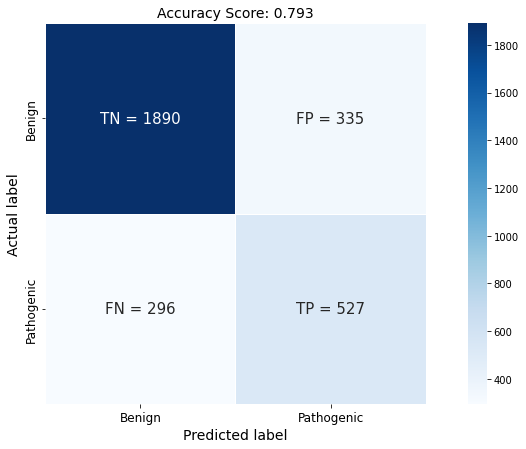

In [82]:
# Generate binary predictions from the model
y_pred = (best_model.predict(X_test) > 0.5).astype(int)
# Generate a confusion matrix using true labels first, then predictions
cm = metrics.confusion_matrix(y_test, y_pred)
#compute accuracy:
score = best_model.evaluate(X_test, y_test, verbose=0)[1]

# Prepare a modified confusion matrix for display
modified_cm = []
for index, value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

# Plot the confusion matrix
plt.figure(figsize=(15, 7))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 15},
            linewidths=.5,
            square=True,
            cmap='Blues',
            xticklabels=['Benign', 'Pathogenic'],
            yticklabels=['Benign', 'Pathogenic'])
plt.ylabel('Actual label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title('Accuracy Score: {:.3f}'.format(score), size=14)
plt.tick_params(labelsize=12)
plt.show()